In [1]:
# colab related
from google.colab import drive
import os

if not os.path.isdir('/content/drive'):
    drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# import shutil
# shutil.rmtree('Data')

In [3]:
# unzip the datafile

!unzip -q /content/drive/MyDrive/DGM/HW2/Data.zip

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import trange
import pickle

In [5]:
# fix the loss calculation in trainer

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

# device = torch.device('cpu')
device = torch.device('cuda')

In [8]:
class BayesianNetwork(nn.Module):
    def __init__(self, margin:int=3, positional:bool=True,num_layer:int=1, activation:str='relu' ):
        super().__init__()
        self.margin = margin
        self.po = positional
        self.num_layer = num_layer
        self.find_input_dim()
        self.activation = activation

        self.model = self.select_model()




        if self.num_layer not in [1,2]:
            raise ValueError('Only networks with one or two layers are valid')

    def forward(self, x):
        x = self.model(x)
        return x

    def select_model(self):
        # Select the model architecture based on given input
        if self.num_layer == 1:
            return self.one_layer_net()
        elif self.num_layer == 2:
            return self.two_layer_net()


    def one_layer_net(self):
        # Model with single layer
        model = nn.Sequential(
                nn.Linear(self.input_dim, 1),
                nn.Sigmoid()
        )
        return model

    def two_layer_net(self):
        # Model with 2 layers
        model = nn.Sequential(
                nn.Linear(self.input_dim, 40),
                self.select_activation(),
                nn.Linear(40, 1),
                nn.Sigmoid()
        )
        return model

    def select_activation(self):
        # Select activatin function based on given input
        if self.activation == 'relu':
            return nn.ReLU()
        elif self.activation == 'silu':
            return nn.SiLU()
        elif self.activation not in ['relu', 'silu']:
            raise ValueError('Only relu and silu activation function are valid')

    def find_input_dim(self):
        # Caluclate input dimention for the network based on it having parents or its padding size
        if self.po:
            self.input_dim = (self.margin+1)**2 + 1
        elif not self.po:
            self.input_dim = (self.margin+1)**2 - 1

    def sample(self,test_im):
        # Sampleing from the model
        blank = np.zeros(shape=(test_im.shape[0]+self.margin, test_im.shape[1]+self.margin))
        # Creating index on the image in the blank image
        idx = np.arange(self.margin,blank.shape[0])
        for i in idx:
            for j in idx:
                x,_ = xy_of_image(
                    test_im.shape[0],
                    blank,
                    i,
                    j,
                    self.margin,
                    self.po
                )
                #‌ Give inputs to the model
                x_tensor,_ = model_input(x,x)
                x_tensor = x_tensor.to(device)
                # Sample from the distribution
                y_hat = self(x_tensor)
                # Generate image based on the sampling score
                pixel_value = (torch.rand(y_hat.shape[0], device=device) < y_hat).float()
                # Add generated image to the blank image
                blank[i, j] = pixel_value.cpu().detach().numpy()
        return blank[self.margin:, self.margin:]

class SingleNLLLoss(nn.Module):
    '''
    Negative Log Likelihood module
    (nn.NLLLoss does not work for networks with single neuron in the last layer)
    '''
    def __init__(self):
        super().__init__()

    def forward(self, predictions, targets):
        predictions = torch.clamp(predictions, min=1e-7, max=1-1e-7)
        loss = -torch.mean(targets * torch.log(predictions) + (1 - targets) * torch.log(1 - predictions))
        return loss


In [9]:
import imageio.v2 as imageio

def xy_of_image(im_size:int, image:np.ndarray, i:int, j:int, margin:int=1, positional:bool=True ) -> tuple[np.ndarray, np.ndarray]:
    '''Extract X (parents) of a pixel (y)'''
    x = image[i-margin:i+1, j-margin:j+1].flatten()
    y = x[-1]
    x = x[:-1]
    if positional:
        #‌ Generate positional features if required
        ax_y = (i-margin)/im_size
        ax_x = (j-margin)/im_size
        x = np.append(x, [ax_x, ax_y])
    return x,y


def image_to_xy(path:str, margin:int=3, positional:bool=True) -> tuple[np.ndarray, np.ndarray]:
    '''Turns an image into training data (path -> read image -> X, y matrices)'''
    image = imageio.imread(path)

    X, Y = image2xy(image, margin, positional)

    return X, Y

def image2xy(image:np.ndarray, margin:int=3, positional:bool=True, return_blank:bool=False) -> tuple[np.ndarray, np.ndarray]:
    '''Turns an image into training data (image -> X, y matrices)'''
    shape_im = image.shape
    new_im = np.zeros(shape=(shape_im[0]+margin, shape_im[1]+margin))
    new_im[margin:, margin:] = image

    idx = np.arange(margin,new_im.shape[0])
    idx_size = idx.shape[0]

    X_list = []
    y_list = []

    for i in idx:
        for j in idx:
            x, y = xy_of_image(idx_size, new_im, i, j, margin, positional)
            X_list.append(x)
            y_list.append(y)

    X = np.array(X_list)
    Y = np.array(y_list)
    if not return_blank:
        return X,Y
    else:
        return X, Y, new_im


def create_dataset(f_names:list, f_label:list, margin:int=1, positional:bool=True) -> tuple[np.ndarray, np.ndarray]:
    '''Create dataset for given image paths'''
    X = np.zeros(shape=(len(f_label)*20*20, (margin+1)**2+1 if positional else (margin+1)**2 -1))
    Y = np.zeros(shape=(len(f_label)*20*20,))

    for i in trange(len(f_label)):
        f_dir = os.path.join(small_dir, f_label[i], f_names[i])
        x, y = image_to_xy(f_dir, margin, positional)
        X[i*20*20:(i+1)*20*20,:] = x
        Y[i*20*20:(i+1)*20*20] = y
    return X, Y

def train_model(model, train_loader, val_loader=None, n_jobs=None, epochs=5, device=device):

    model.model.to(device)
    if n_jobs:
        torch.set_num_threads(n_jobs)  # Set number of threads to be used

    # Use CrossEntropyLoss for classification tasks
    criterion = SingleNLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    train_loss_list = []
    train_iteration_loss_list = []
    val_loss_list = []

    # Generate an image with non-trained model with random weights
    gen_im = model.sample(np.zeros(shape=(20,20)))
    plt.figure()
    plt.imshow(gen_im)
    plt.title('Generated image for untrained model')
    plt.show()

    try:
        for epoch in range(epochs):
            model.train()
            train_loss = 0
            train_iteration_loss_list = []

            # Train loop
            pbar = trange(len(train_loader), desc=f'Epoch {epoch+1}/{epochs}')
            for i, (X_batch, y_batch) in zip(pbar, train_loader):
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                y_batch_hat = model(X_batch)
                loss = criterion(y_batch_hat, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                batch_loss = loss.item()
                train_iteration_loss_list.append(batch_loss)
                pbar.set_postfix_str(f'train loss: {sum(train_iteration_loss_list) / len(train_iteration_loss_list):.4f}')

            epoch_train_loss = sum(train_iteration_loss_list) / len(train_iteration_loss_list)
            train_loss_list.append(epoch_train_loss)

            if val_loader:
                # Validation loop
                model.eval()
                val_iteration_loss_list = []
                with torch.no_grad():
                    for X_val, y_val in val_loader:
                        X_val = X_val.to(device)
                        y_val = y_val.to(device)

                        y_val_hat = model(X_val)
                        loss = criterion(y_val_hat, y_val)
                        val_iteration_loss_list.append(loss.item())

                    epoch_val_loss = sum(val_iteration_loss_list) / len(val_iteration_loss_list)
                    val_loss_list.append(epoch_val_loss)
                print(f'Validation Loss: {epoch_val_loss:.4f}')


            # generate image
            gen_im = model.sample(np.zeros(shape=(20,20)))
            plt.figure()
            plt.imshow(gen_im)
            plt.title('Generated image')
            plt.show()

        return train_loss_list, val_loss_list, train_iteration_loss_list

    except KeyboardInterrupt:
        # In case of Interrupting, the function returns the list for losses
        print('\n\n!!!!!!!! Training has been stopped !!!!!!!!')
        return train_loss_list, val_loss_list, train_iteration_loss_list


def model_input(x=None, y=None):
    '''Prepare data for model (Turn numpy array into torch tensor)'''
    x_tensor = torch.tensor(x, dtype=torch.float32)
    y_tensor = torch.tensor(y/255, dtype=torch.long)
    return x_tensor, y_tensor

## Work with data

In [10]:
# Directories for images
small_dir = r'Data/small'
med_dir = r'Data/mid'
big_dir = r'Data/big'

s_folders = os.listdir(small_dir)
m_folders = os.listdir(med_dir)
b_folders = os.listdir(big_dir)

Read all file names

In [11]:
f_names = []
f_label = []

for root, dirs, files in os.walk(small_dir):

    if len(root.split("/")) == 3:
        label = root.split('/')[-1]
        for f in files:
            f_names.append(f)
            f_label.append(label)


splitting the data into train, validation and test

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# Creating test and train data
f_train, f_test, l_train, l_test = train_test_split(
    f_names,
    f_label,
    test_size = 0.1,
    shuffle = True,
    random_state = 69
)

# Creating Train and Validation data
f_train, f_val, l_train, l_val = train_test_split(
    f_train,
    l_train,
    test_size = 0.111,
    shuffle = True,
    random_state = 69
)

# Margin size 1

## Positional = True

Read images to create trainnig data

In [ ]:
MARGIN = 1
POSITIONAL = True

print('Create Train dataset')
X_train, y_train = create_dataset(f_train, l_train, MARGIN, POSITIONAL)
print('Create Validation dataset')
X_val, y_val = create_dataset(f_val, l_val, MARGIN, POSITIONAL)

Create Train dataset


100%|██████████| 10447/10447 [00:35<00:00, 292.02it/s]


Create Validation dataset


100%|██████████| 1305/1305 [00:03<00:00, 366.84it/s]


In [ ]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

with open(f"scaler_{MARGIN}_{POSITIONAL}.pkl", "wb") as f:
    pickle.dump(scaler, f)

# with open("scaler.pkl", "rb") as f:
#     loaded_scaler = pickle.load(f)

In [ ]:
X_val_tensor, y_val_tensor = model_input(X_val, y_val)
val_tensor = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_tensor, shuffle=False, batch_size=2**14)

X_train_tensor, y_train_tensor = model_input(X_train, y_train)
train_tensor = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_tensor, shuffle=False, batch_size=2**14)

In [ ]:
X_train_tensor.shape

torch.Size([4178800, 5])

### Model

In [ ]:
single_layer_model = BayesianNetwork(1, True, num_layer=1).to(device)
double_layer_model_r = BayesianNetwork(1, True, num_layer=2, activation='relu').to(device)
double_layer_model_s = BayesianNetwork(1, True, num_layer=2, activation='silu').to(device)

******* Train single layer model *******


<ipython-input-27-7a21389e0ef8>:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  blank[i, j] = pixel_value.cpu().detach().numpy()


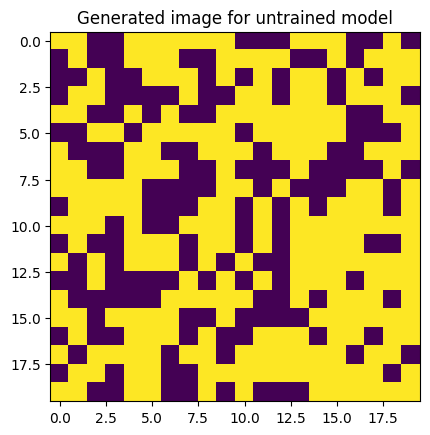

Epoch 1/100: 100%|██████████| 256/256 [01:11<00:00,  3.56it/s, train loss: 1.6927]


Validation Loss: 1.5374


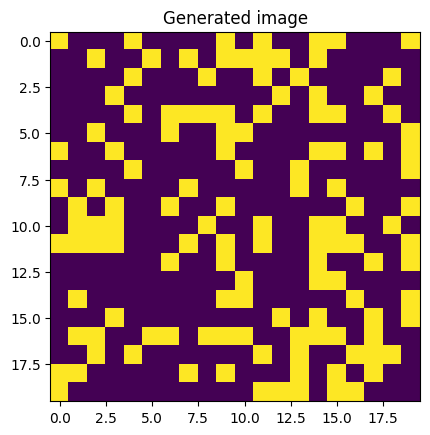

Epoch 2/100: 100%|██████████| 256/256 [01:11<00:00,  3.57it/s, train loss: 1.4885]


Validation Loss: 1.4457


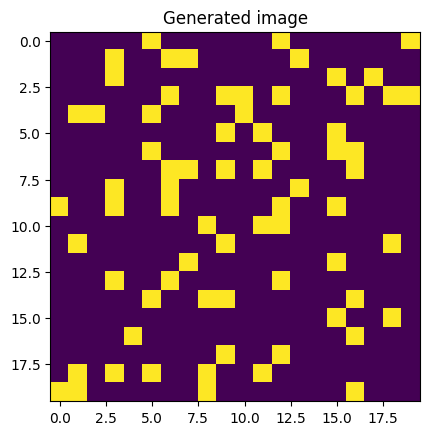

Epoch 3/100: 100%|██████████| 256/256 [01:12<00:00,  3.54it/s, train loss: 1.4348]


Validation Loss: 1.4157


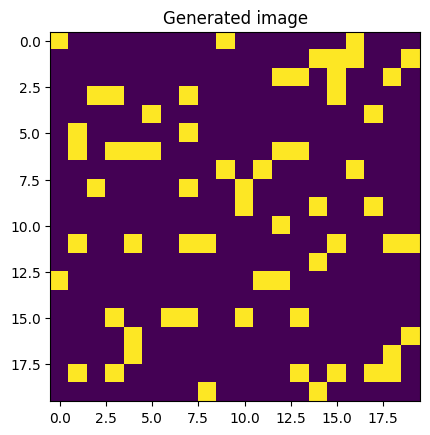

Epoch 4/100: 100%|██████████| 256/256 [01:13<00:00,  3.50it/s, train loss: 1.4153]


Validation Loss: 1.4034


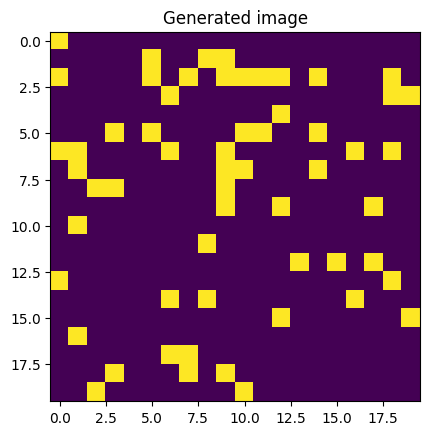

Epoch 5/100: 100%|██████████| 256/256 [01:13<00:00,  3.49it/s, train loss: 1.4067]


Validation Loss: 1.3975


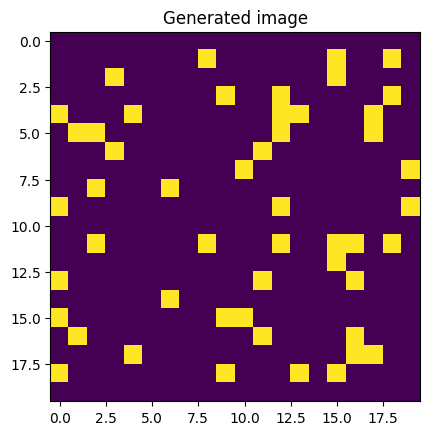

Epoch 6/100: 100%|██████████| 256/256 [01:18<00:00,  3.24it/s, train loss: 1.4025]


Validation Loss: 1.3945


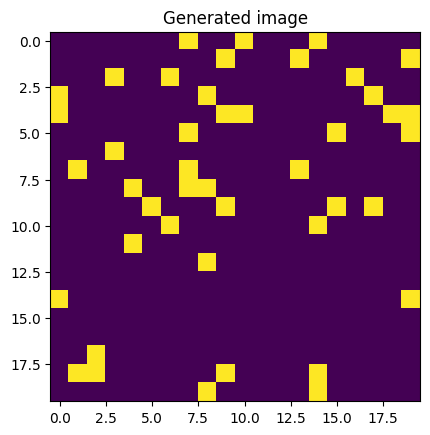

Epoch 7/100: 100%|██████████| 256/256 [01:14<00:00,  3.41it/s, train loss: 1.4003]


Validation Loss: 1.3929


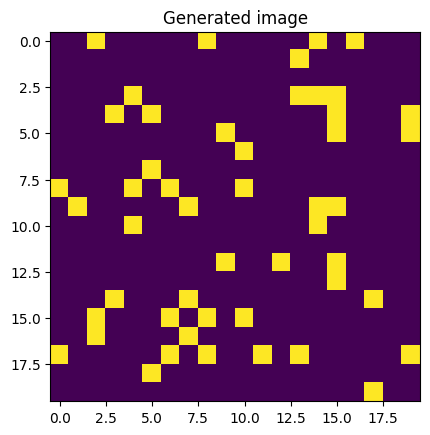

Epoch 8/100: 100%|██████████| 256/256 [01:18<00:00,  3.26it/s, train loss: 1.3991]


Validation Loss: 1.3919


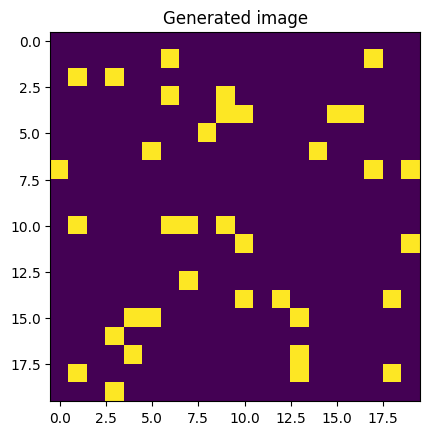

Epoch 9/100: 100%|██████████| 256/256 [01:14<00:00,  3.45it/s, train loss: 1.3984]


Validation Loss: 1.3914


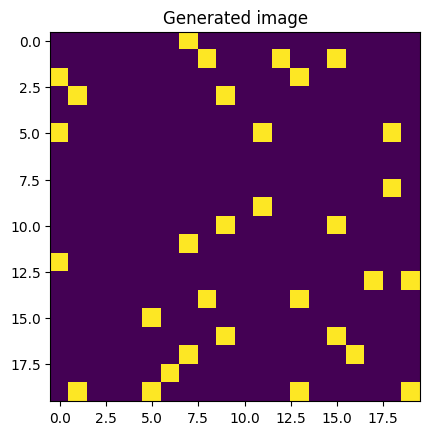

Epoch 10/100: 100%|██████████| 256/256 [01:14<00:00,  3.42it/s, train loss: 1.3979]


Validation Loss: 1.3910


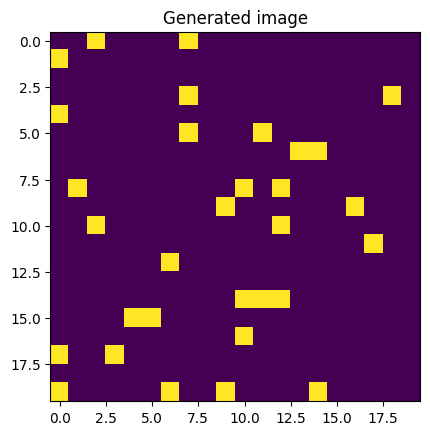

Epoch 11/100: 100%|██████████| 256/256 [01:14<00:00,  3.44it/s, train loss: 1.3977]


Validation Loss: 1.3908


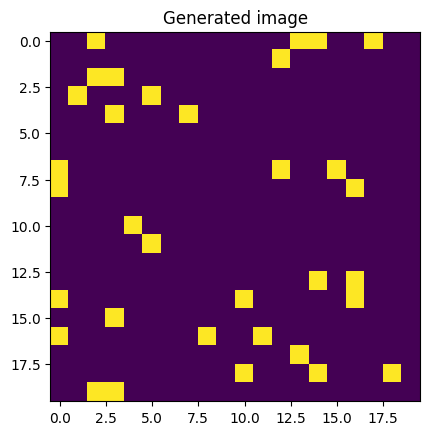

Epoch 12/100: 100%|██████████| 256/256 [01:13<00:00,  3.48it/s, train loss: 1.3975]


Validation Loss: 1.3906


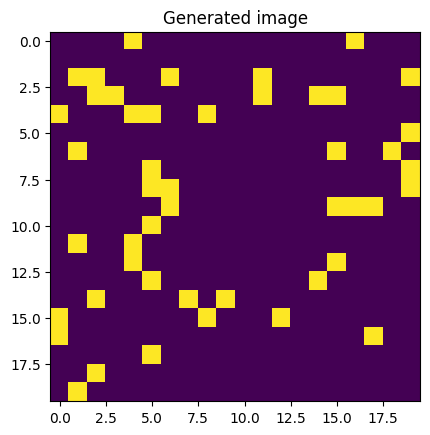

Epoch 13/100: 100%|██████████| 256/256 [01:14<00:00,  3.44it/s, train loss: 1.3974]


Validation Loss: 1.3905


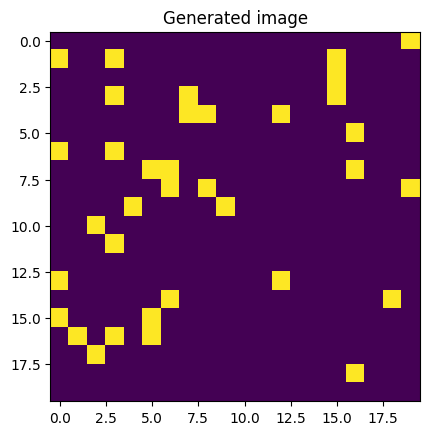

Epoch 14/100: 100%|██████████| 256/256 [01:13<00:00,  3.46it/s, train loss: 1.3973]


Validation Loss: 1.3905


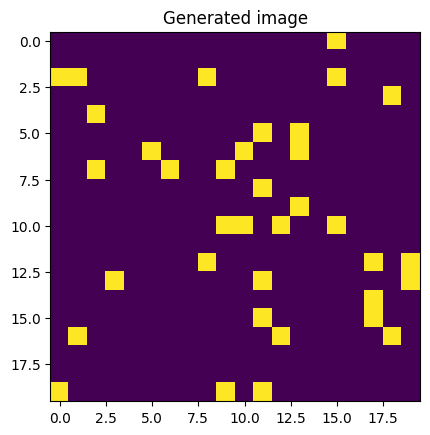

Epoch 15/100: 100%|██████████| 256/256 [01:13<00:00,  3.48it/s, train loss: 1.3972]


Validation Loss: 1.3904


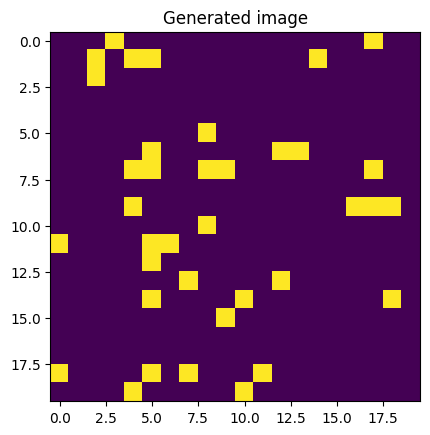

Epoch 16/100: 100%|██████████| 256/256 [01:14<00:00,  3.42it/s, train loss: 1.3972]


Validation Loss: 1.3904


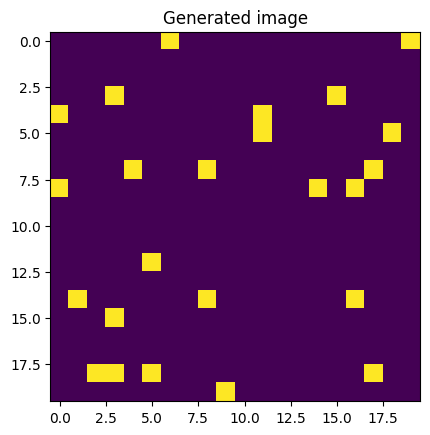

Epoch 17/100: 100%|██████████| 256/256 [01:14<00:00,  3.44it/s, train loss: 1.3972]


Validation Loss: 1.3903


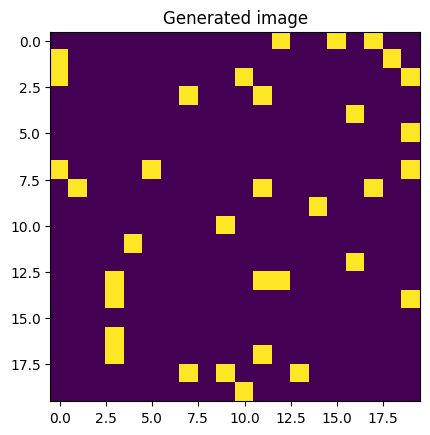

Epoch 18/100: 100%|██████████| 256/256 [01:15<00:00,  3.39it/s, train loss: 1.3971]


Validation Loss: 1.3903


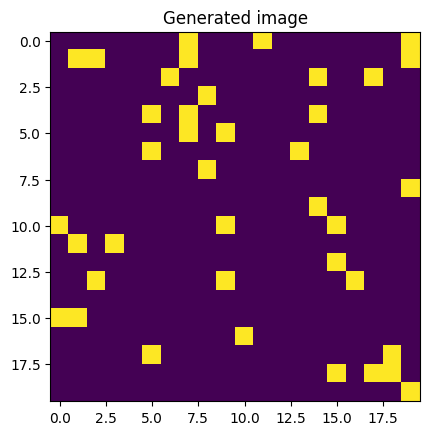

Epoch 19/100: 100%|██████████| 256/256 [01:15<00:00,  3.37it/s, train loss: 1.3971]


Validation Loss: 1.3903


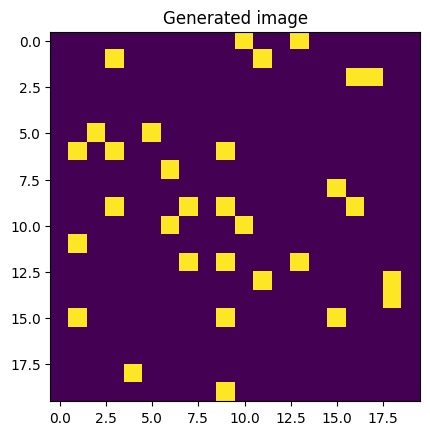

Epoch 20/100: 100%|██████████| 256/256 [01:14<00:00,  3.42it/s, train loss: 1.3971]


Validation Loss: 1.3902


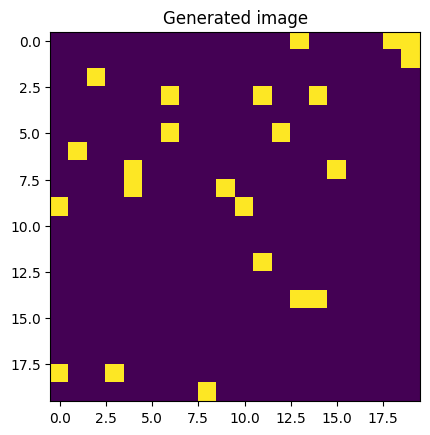

Epoch 21/100:  11%|█▏        | 29/256 [00:08<01:09,  3.26it/s, train loss: 1.4123]




!!!!!!!! Training has been stopped !!!!!!!!



******* Train double layer model with relu *******


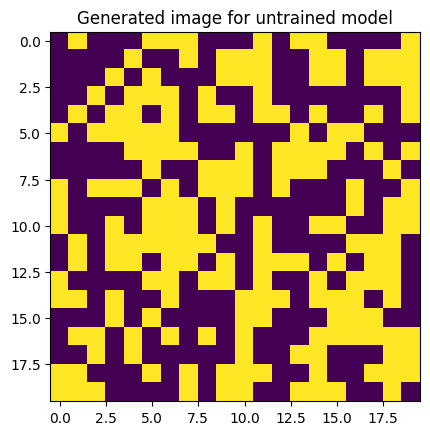

Epoch 1/100: 100%|██████████| 256/256 [01:15<00:00,  3.38it/s, train loss: 0.4965]


Validation Loss: 0.3937


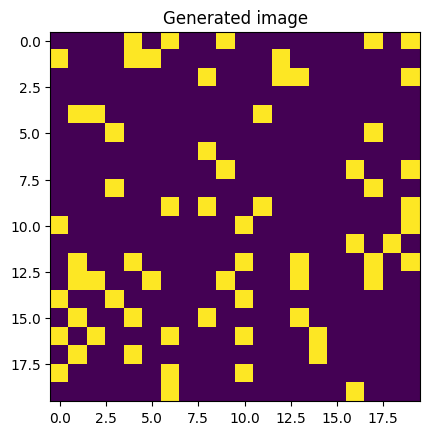

Epoch 2/100: 100%|██████████| 256/256 [01:17<00:00,  3.29it/s, train loss: 0.3739]


Validation Loss: 0.3636


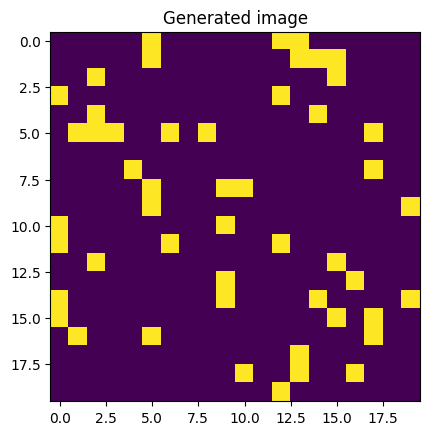

Epoch 3/100: 100%|██████████| 256/256 [01:15<00:00,  3.37it/s, train loss: 0.3615]


Validation Loss: 0.3601


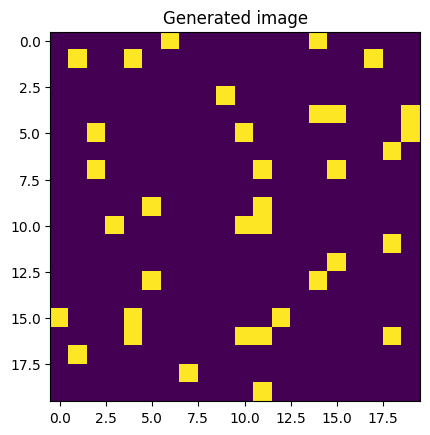

Epoch 4/100: 100%|██████████| 256/256 [01:16<00:00,  3.37it/s, train loss: 0.3599]


Validation Loss: 0.3596


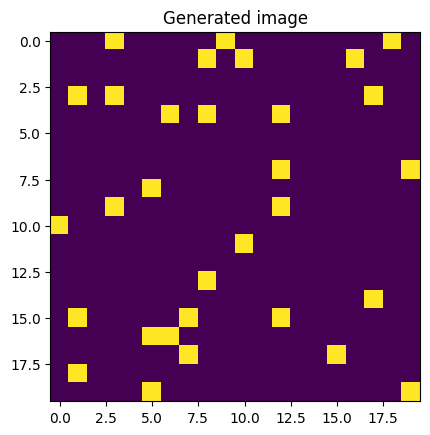

Epoch 5/100: 100%|██████████| 256/256 [01:15<00:00,  3.37it/s, train loss: 0.3596]


Validation Loss: 0.3594


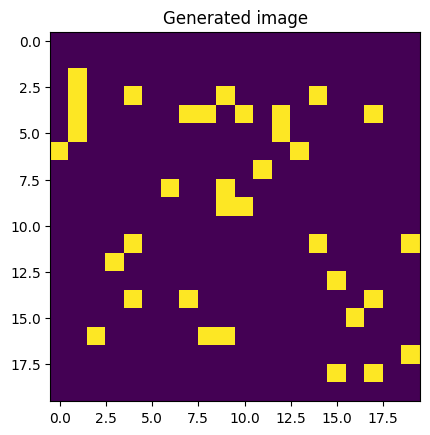

Epoch 6/100: 100%|██████████| 256/256 [01:16<00:00,  3.36it/s, train loss: 0.3595]


Validation Loss: 0.3593


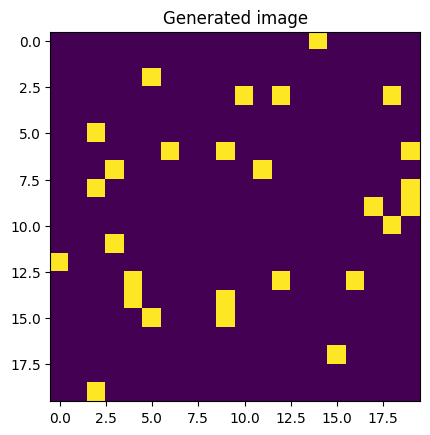

Epoch 7/100: 100%|██████████| 256/256 [01:18<00:00,  3.25it/s, train loss: 0.3594]


Validation Loss: 0.3593


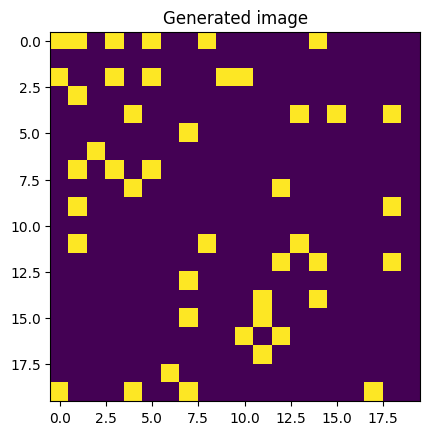

Epoch 8/100: 100%|██████████| 256/256 [01:16<00:00,  3.34it/s, train loss: 0.3594]


Validation Loss: 0.3592


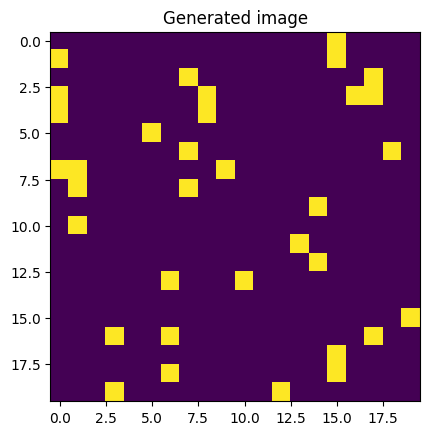

Epoch 9/100: 100%|██████████| 256/256 [01:30<00:00,  2.83it/s, train loss: 0.3593]


Validation Loss: 0.3592


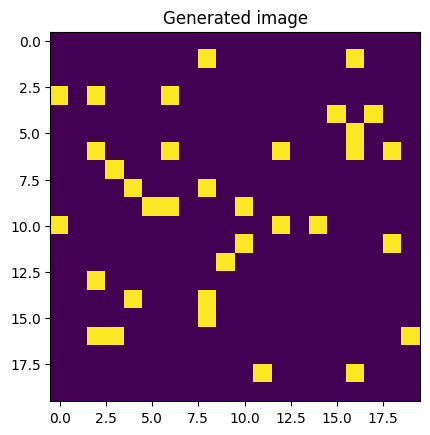

Epoch 10/100: 100%|██████████| 256/256 [01:22<00:00,  3.11it/s, train loss: 0.3593]


Validation Loss: 0.3591


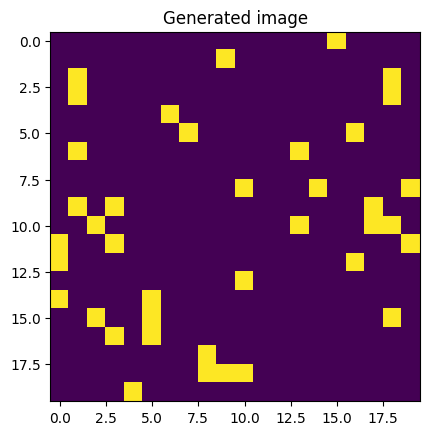

Epoch 11/100: 100%|██████████| 256/256 [01:20<00:00,  3.18it/s, train loss: 0.3592]


Validation Loss: 0.3590


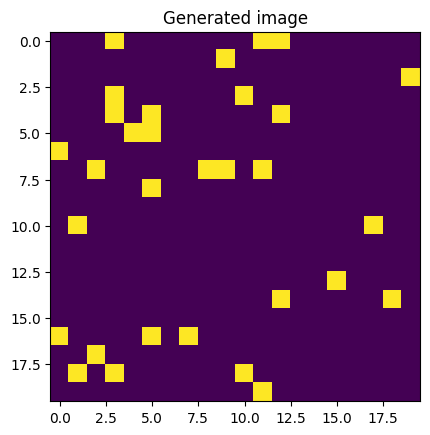

Epoch 12/100: 100%|██████████| 256/256 [01:16<00:00,  3.34it/s, train loss: 0.3591]


Validation Loss: 0.3590


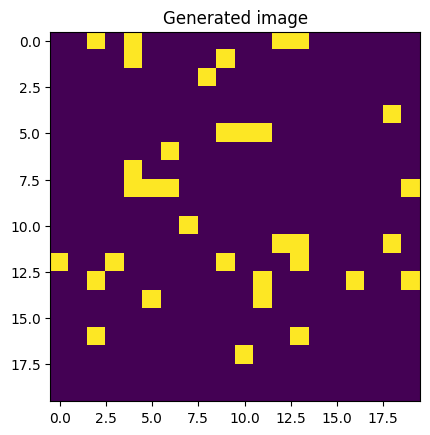

Epoch 13/100: 100%|██████████| 256/256 [01:16<00:00,  3.34it/s, train loss: 0.3591]


Validation Loss: 0.3589


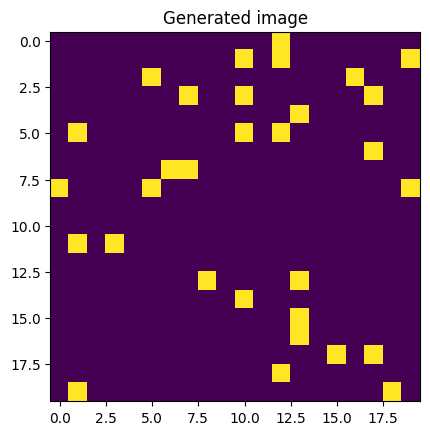

Epoch 14/100: 100%|██████████| 256/256 [01:16<00:00,  3.36it/s, train loss: 0.3591]


Validation Loss: 0.3589


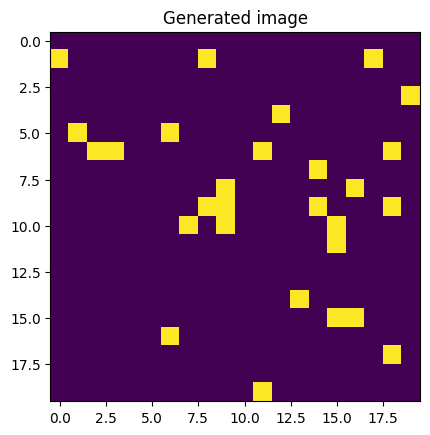

Epoch 15/100: 100%|██████████| 256/256 [01:15<00:00,  3.39it/s, train loss: 0.3590]


Validation Loss: 0.3588


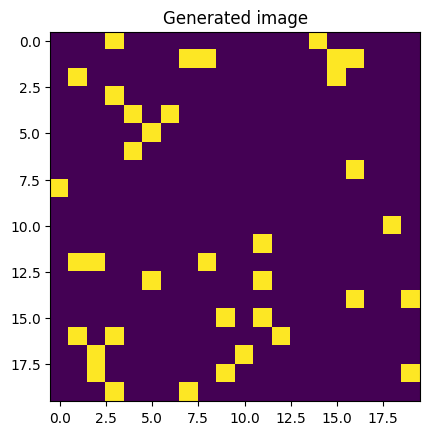

Epoch 16/100: 100%|██████████| 256/256 [01:15<00:00,  3.38it/s, train loss: 0.3590]


Validation Loss: 0.3588


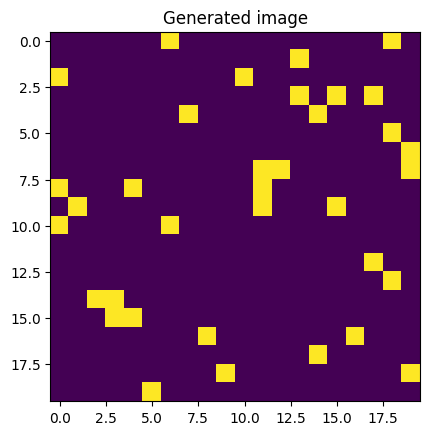

Epoch 17/100: 100%|██████████| 256/256 [01:20<00:00,  3.18it/s, train loss: 0.3589]


Validation Loss: 0.3587


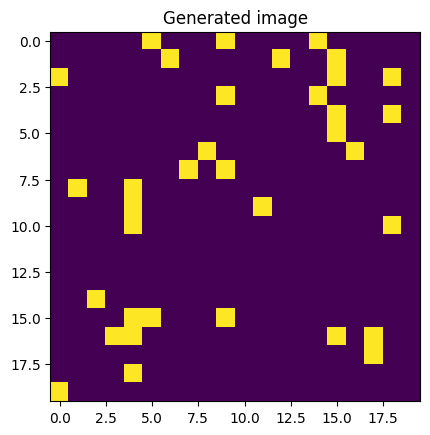

Epoch 18/100: 100%|██████████| 256/256 [01:15<00:00,  3.37it/s, train loss: 0.3589]


Validation Loss: 0.3587


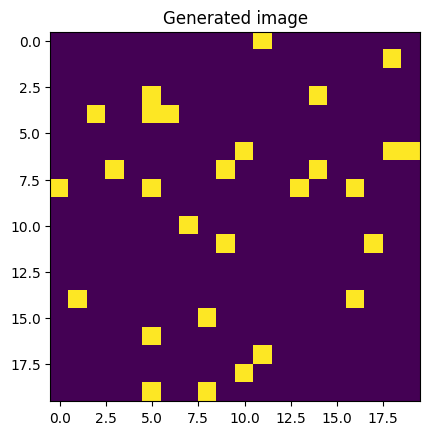

Epoch 19/100: 100%|██████████| 256/256 [01:17<00:00,  3.32it/s, train loss: 0.3589]


Validation Loss: 0.3586


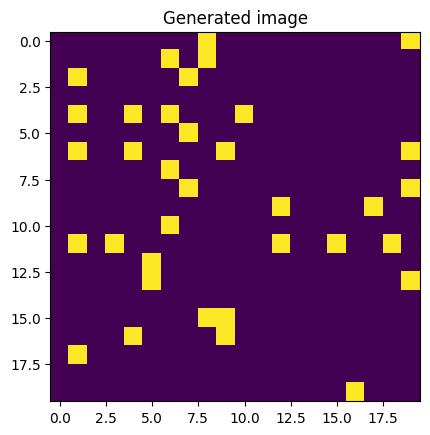

Epoch 20/100: 100%|██████████| 256/256 [01:16<00:00,  3.36it/s, train loss: 0.3588]


Validation Loss: 0.3586


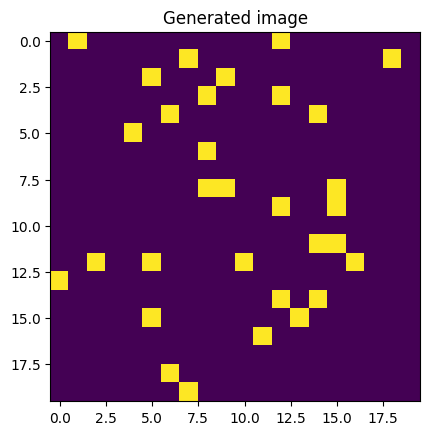

Epoch 21/100:  17%|█▋        | 43/256 [00:13<01:05,  3.26it/s, train loss: 0.3645]




!!!!!!!! Training has been stopped !!!!!!!!



******* Train double layer model with silu *******


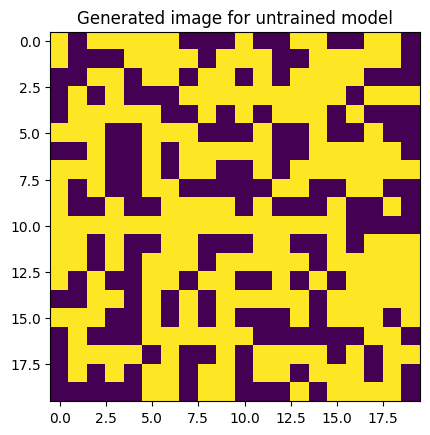

Epoch 1/100: 100%|██████████| 256/256 [01:16<00:00,  3.37it/s, train loss: 0.5584]


Validation Loss: 0.4311


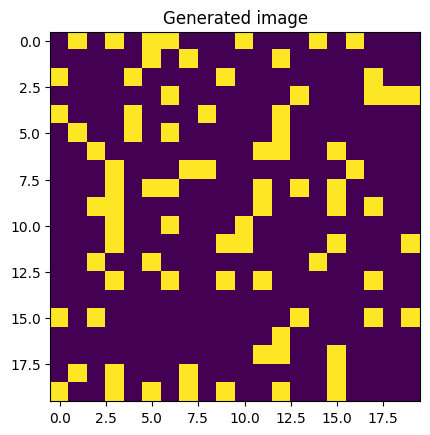

Epoch 2/100: 100%|██████████| 256/256 [01:17<00:00,  3.30it/s, train loss: 0.4000]


Validation Loss: 0.3801


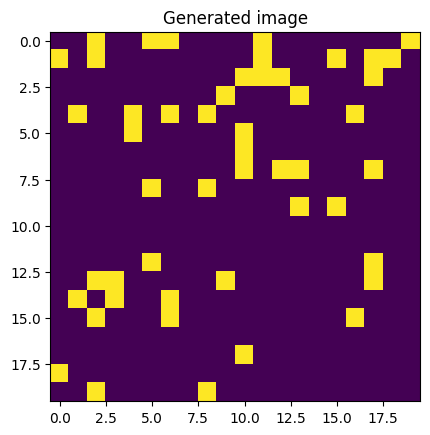

Epoch 3/100: 100%|██████████| 256/256 [01:16<00:00,  3.35it/s, train loss: 0.3757]


Validation Loss: 0.3704


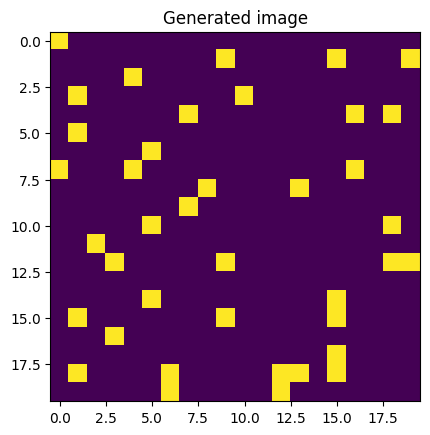

Epoch 4/100: 100%|██████████| 256/256 [01:15<00:00,  3.39it/s, train loss: 0.3709]


Validation Loss: 0.3683


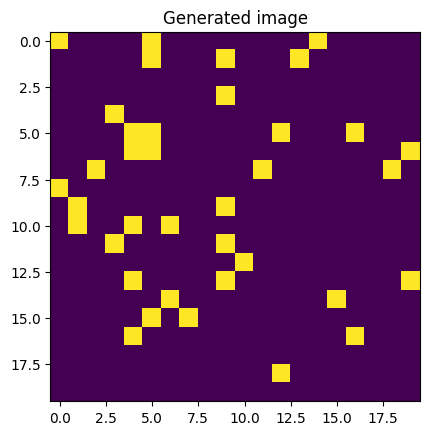

Epoch 5/100: 100%|██████████| 256/256 [01:18<00:00,  3.27it/s, train loss: 0.3697]


Validation Loss: 0.3677


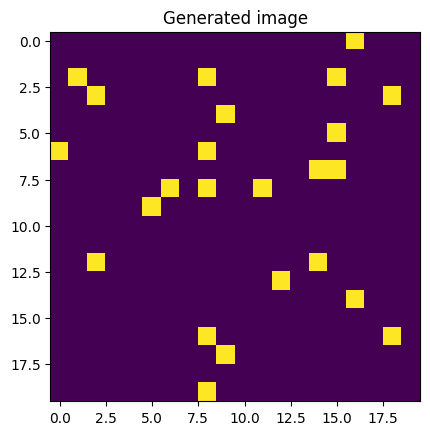

Epoch 6/100: 100%|██████████| 256/256 [01:15<00:00,  3.37it/s, train loss: 0.3694]


Validation Loss: 0.3675


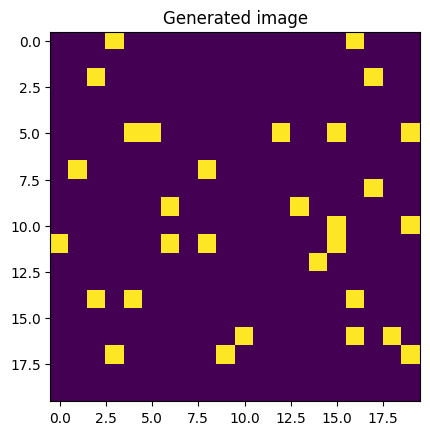

Epoch 7/100: 100%|██████████| 256/256 [01:16<00:00,  3.33it/s, train loss: 0.3692]


Validation Loss: 0.3674


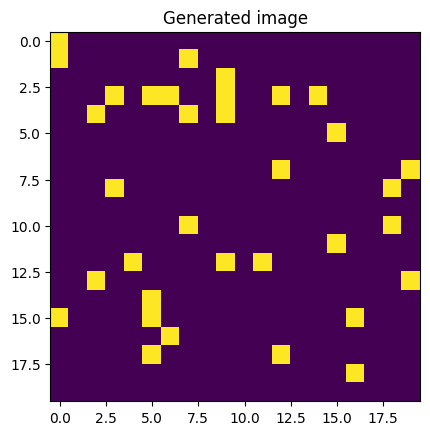

Epoch 8/100: 100%|██████████| 256/256 [01:17<00:00,  3.30it/s, train loss: 0.3691]


Validation Loss: 0.3673


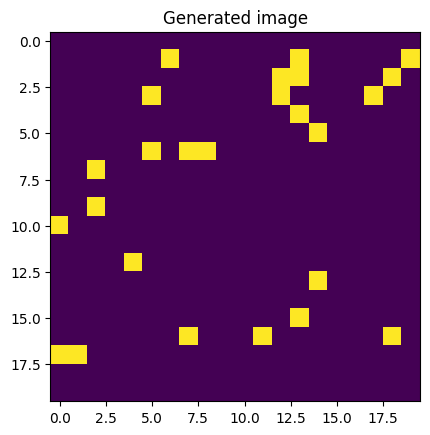

Epoch 9/100: 100%|██████████| 256/256 [01:17<00:00,  3.32it/s, train loss: 0.3691]


Validation Loss: 0.3672


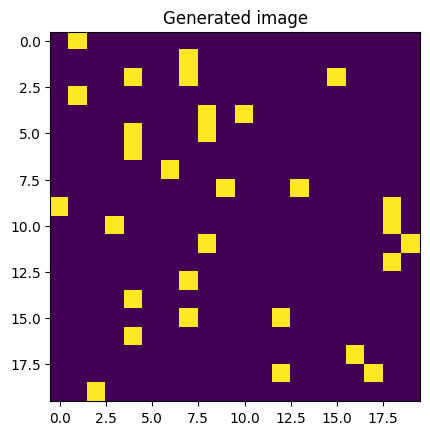

Epoch 10/100: 100%|██████████| 256/256 [01:16<00:00,  3.33it/s, train loss: 0.3690]


Validation Loss: 0.3671


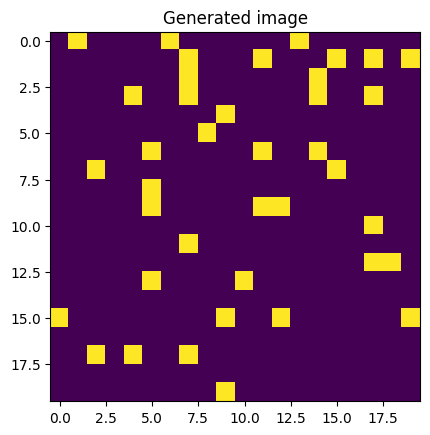

Epoch 11/100: 100%|██████████| 256/256 [01:17<00:00,  3.30it/s, train loss: 0.3689]


Validation Loss: 0.3671


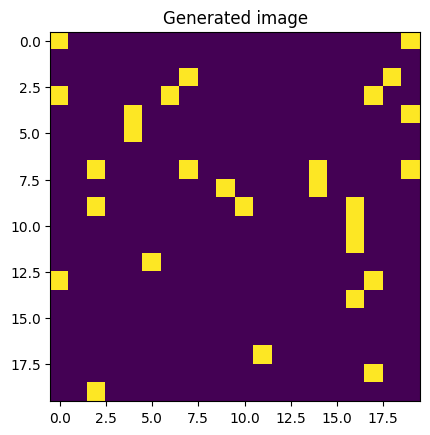

Epoch 12/100: 100%|██████████| 256/256 [01:16<00:00,  3.35it/s, train loss: 0.3689]


Validation Loss: 0.3670


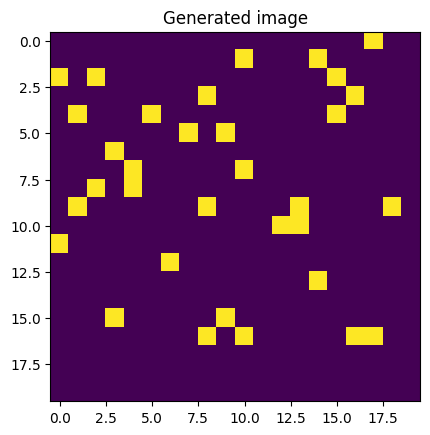

Epoch 13/100: 100%|██████████| 256/256 [01:17<00:00,  3.30it/s, train loss: 0.3688]


Validation Loss: 0.3670


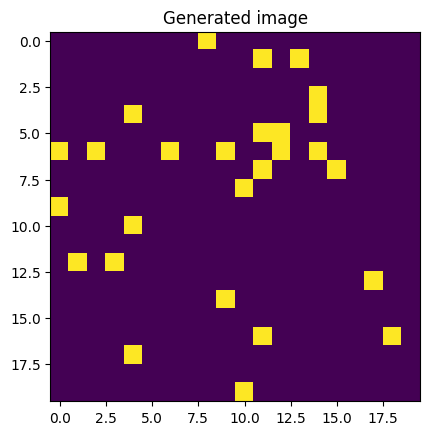

Epoch 14/100: 100%|██████████| 256/256 [01:17<00:00,  3.29it/s, train loss: 0.3688]


Validation Loss: 0.3669


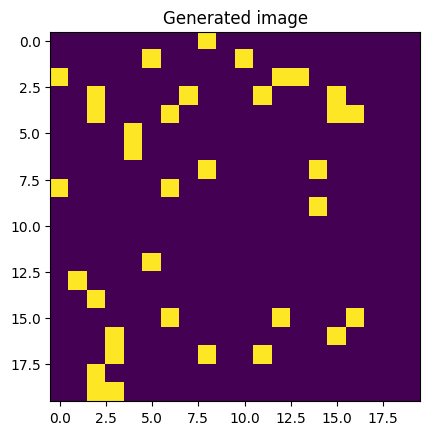

Epoch 15/100: 100%|██████████| 256/256 [01:18<00:00,  3.28it/s, train loss: 0.3687]


Validation Loss: 0.3669


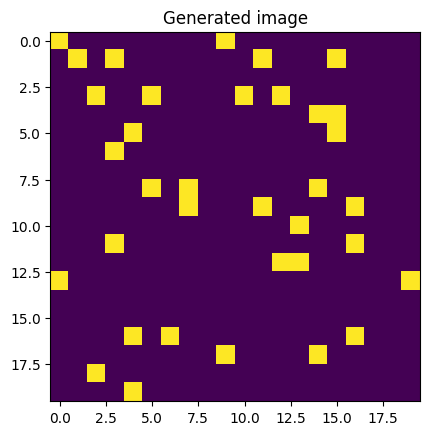

Epoch 16/100: 100%|██████████| 256/256 [01:16<00:00,  3.33it/s, train loss: 0.3687]


Validation Loss: 0.3668


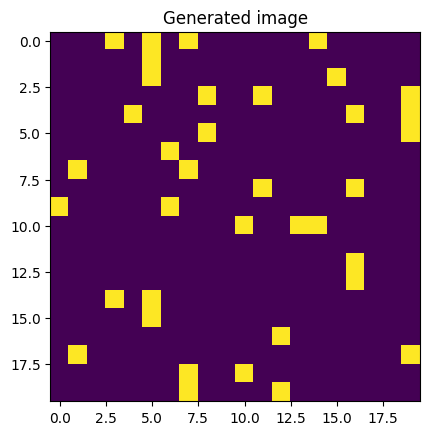

Epoch 17/100: 100%|██████████| 256/256 [01:18<00:00,  3.28it/s, train loss: 0.3686]


Validation Loss: 0.3668


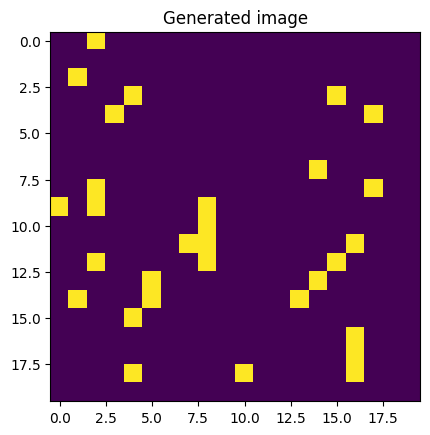

Epoch 18/100: 100%|██████████| 256/256 [01:17<00:00,  3.29it/s, train loss: 0.3686]


Validation Loss: 0.3667


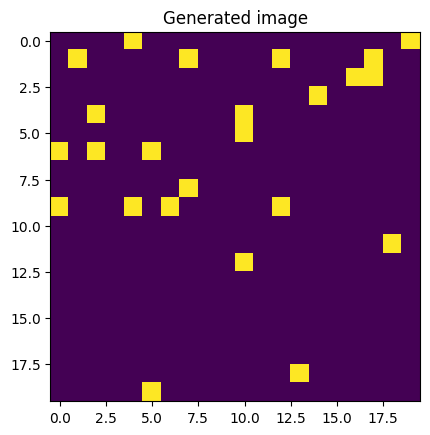

Epoch 19/100: 100%|██████████| 256/256 [01:20<00:00,  3.19it/s, train loss: 0.3685]


Validation Loss: 0.3667


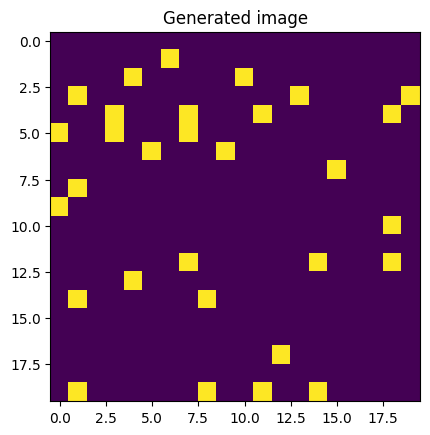

Epoch 20/100: 100%|██████████| 256/256 [01:17<00:00,  3.30it/s, train loss: 0.3685]


Validation Loss: 0.3666


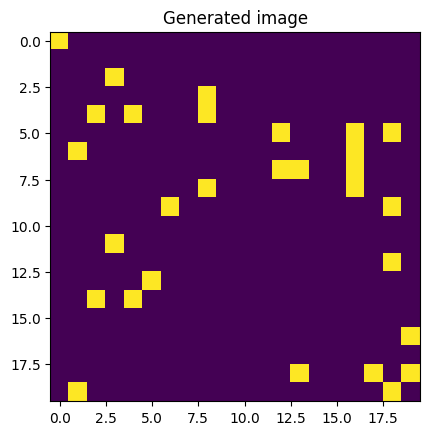

Epoch 21/100:  32%|███▏      | 83/256 [00:25<00:53,  3.23it/s, train loss: 0.3691]



!!!!!!!! Training has been stopped !!!!!!!!


In [ ]:
print('******* Train single layer model *******')
signle_history = train_model(single_layer_model, train_loader, val_loader, epochs=20)
print('\n\n')
print('******* Train double layer model with relu *******')
double_r_history = train_model(double_layer_model_r, train_loader, val_loader, epochs=20)
print('\n\n')
print('******* Train double layer model with silu *******')
double_s_history = train_model(double_layer_model_s, train_loader, val_loader, epochs=20)


In [ ]:
# Save model weights
torch.save(single_layer_model.state_dict(), f'/content/drive/MyDrive/DGM/HW2/weights/ss_{MARGIN}_{POSITIONAL}.pth')
torch.save(double_layer_model_r.state_dict(), f'/content/drive/MyDrive/DGM/HW2/weights/dr_{MARGIN}_{POSITIONAL}.pth')
torch.save(double_layer_model_s.state_dict(), f'/content/drive/MyDrive/DGM/HW2/weights/ds_{MARGIN}_{POSITIONAL}.pth')

Generating digits

<ipython-input-27-7a21389e0ef8>:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  blank[i, j] = pixel_value.cpu().detach().numpy()


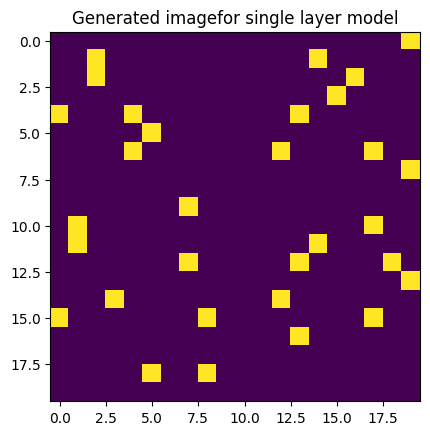

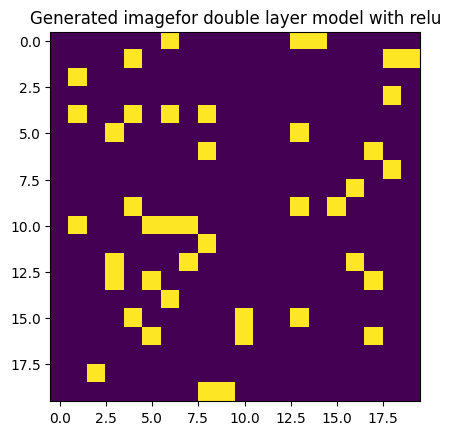

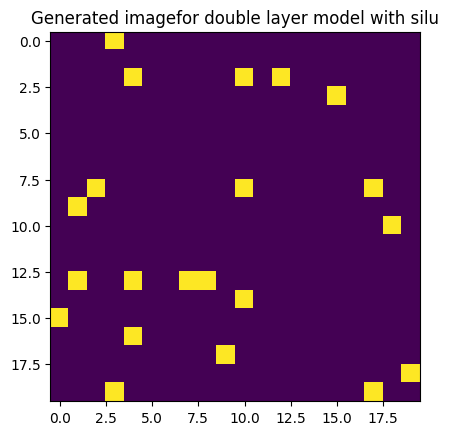

In [ ]:
# Generate digit
gen_im = single_layer_model.sample(np.zeros(shape=(20,20)))
plt.figure()
plt.imshow(gen_im)
plt.title('Generated imagefor single layer model')
plt.show()

gen_im = double_layer_model_r.sample(np.zeros(shape=(20,20)))
plt.figure()
plt.imshow(gen_im)
plt.title('Generated imagefor double layer model with relu')
plt.show()

gen_im = double_layer_model_s.sample(np.zeros(shape=(20,20)))
plt.figure()
plt.imshow(gen_im)
plt.title('Generated imagefor double layer model with silu')
plt.show()

Text(0, 0.5, 'loss')

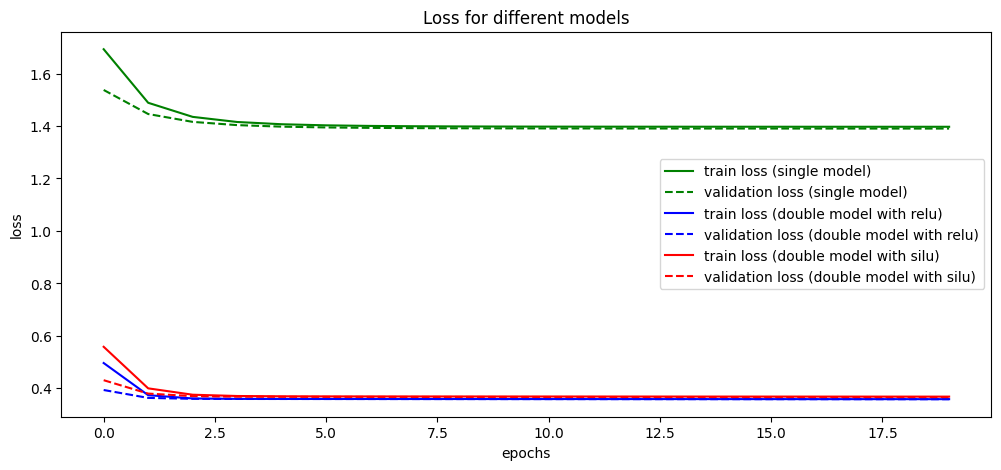

In [ ]:
# Plot loss history
plt.figure(figsize=(12,5))
plt.plot(signle_history[0], 'g-', label='train loss (single model)')
plt.plot(signle_history[1], 'g--', label='validation loss (single model)')
plt.plot(double_r_history[0], 'b-', label='train loss (double model with relu)')
plt.plot(double_r_history[1], 'b--', label='validation loss (double model with relu)')
plt.plot(double_s_history[0], 'r-', label='train loss (double model with silu)')
plt.plot(double_s_history[1], 'r--', label='validation loss (double model with silu)')

plt.title('Loss for different models')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

In [ ]:
# save arrays of loss
folder_dir = '/content/drive/MyDrive/DGM/HW2/files'

with open(os.path.join(folder_dir,f'ss_{MARGIN}_{POSITIONAL}.pkl' ), 'wb') as file:
    pickle.dump(signle_history, file)
with open(os.path.join(folder_dir,f'dr_{MARGIN}_{POSITIONAL}.pkl' ), 'wb') as file:
    pickle.dump(signle_history, file)
with open(os.path.join(folder_dir,f'ds_{MARGIN}_{POSITIONAL}.pkl' ), 'wb') as file:
    pickle.dump(signle_history, file)

## Positional = False

Read images to create trainnig data

In [14]:
MARGIN = 1
POSITIONAL = False

print('Create Train dataset')
X_train, y_train = create_dataset(f_train, l_train, MARGIN, POSITIONAL)
print('Create Validation dataset')
X_val, y_val = create_dataset(f_val, l_val, MARGIN, POSITIONAL)

Create Train dataset


100%|██████████| 10447/10447 [00:18<00:00, 562.93it/s]


Create Validation dataset


100%|██████████| 1305/1305 [00:02<00:00, 610.58it/s]


In [15]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

with open(f"scaler_{MARGIN}_{POSITIONAL}.pkl", "wb") as f:
    pickle.dump(scaler, f)

# with open("scaler.pkl", "rb") as f:
#     loaded_scaler = pickle.load(f)

In [16]:
X_val_tensor, y_val_tensor = model_input(X_val, y_val)
val_tensor = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_tensor, shuffle=False, batch_size=2**14)

X_train_tensor, y_train_tensor = model_input(X_train, y_train)
train_tensor = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_tensor, shuffle=False, batch_size=2**14)

### Model

In [17]:
single_layer_model = BayesianNetwork(MARGIN, POSITIONAL, num_layer=1).to(device)
double_layer_model_r = BayesianNetwork(MARGIN, POSITIONAL, num_layer=2, activation='relu').to(device)
double_layer_model_s = BayesianNetwork(MARGIN, POSITIONAL, num_layer=2, activation='silu').to(device)

******* Train single layer model *******



******* Train double layer model with relu *******


<ipython-input-8-58bb2c42bf67>:87: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  blank[i, j] = pixel_value.cpu().detach().numpy()


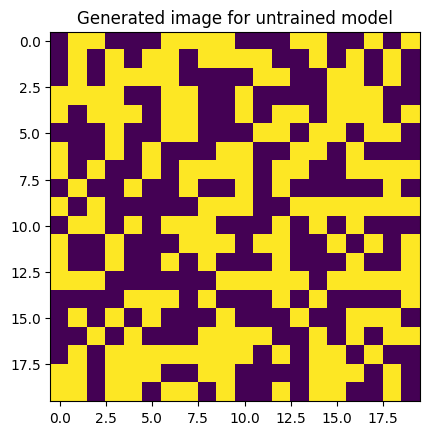

Epoch 1/20: 100%|██████████| 256/256 [01:19<00:00,  3.23it/s, train loss: 0.5069]


Validation Loss: 0.4136


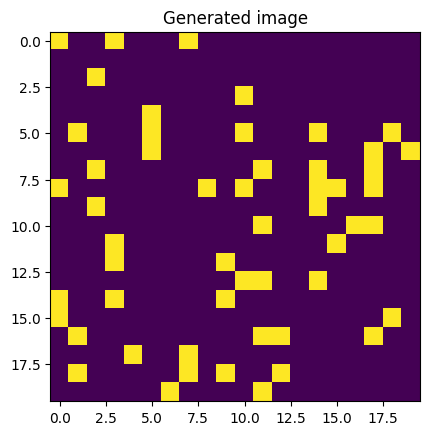

Epoch 2/20: 100%|██████████| 256/256 [01:21<00:00,  3.16it/s, train loss: 0.3999]


Validation Loss: 0.3897


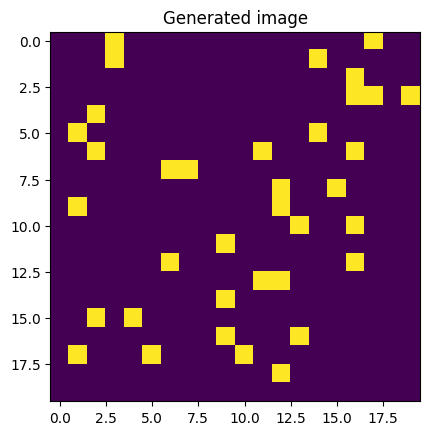

Epoch 3/20: 100%|██████████| 256/256 [01:27<00:00,  2.93it/s, train loss: 0.3898]


Validation Loss: 0.3864


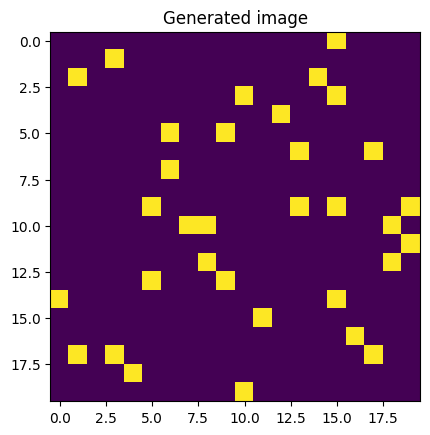

Epoch 4/20: 100%|██████████| 256/256 [01:21<00:00,  3.14it/s, train loss: 0.3884]


Validation Loss: 0.3858


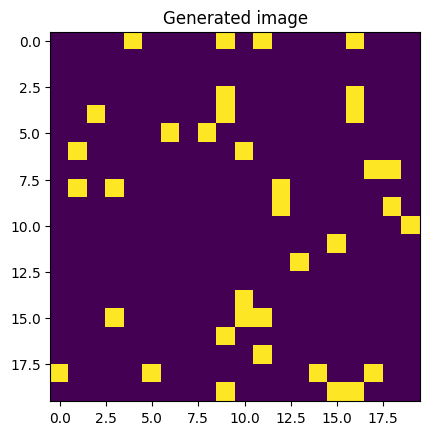

Epoch 5/20: 100%|██████████| 256/256 [01:17<00:00,  3.29it/s, train loss: 0.3881]


Validation Loss: 0.3857


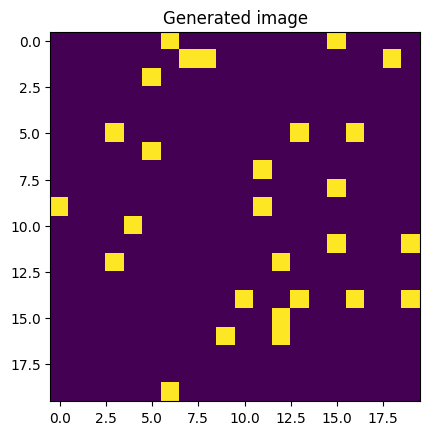

Epoch 6/20: 100%|██████████| 256/256 [01:17<00:00,  3.31it/s, train loss: 0.3881]


Validation Loss: 0.3857


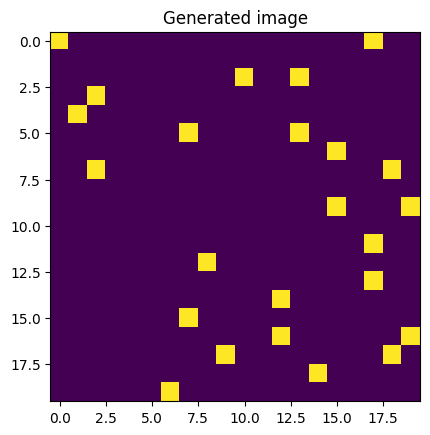

Epoch 7/20: 100%|██████████| 256/256 [01:17<00:00,  3.28it/s, train loss: 0.3881]


Validation Loss: 0.3857


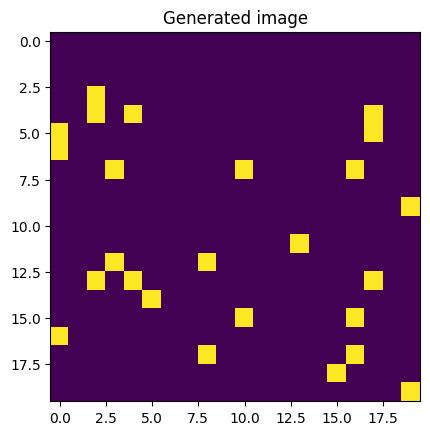

Epoch 8/20: 100%|██████████| 256/256 [01:17<00:00,  3.30it/s, train loss: 0.3880]


Validation Loss: 0.3857


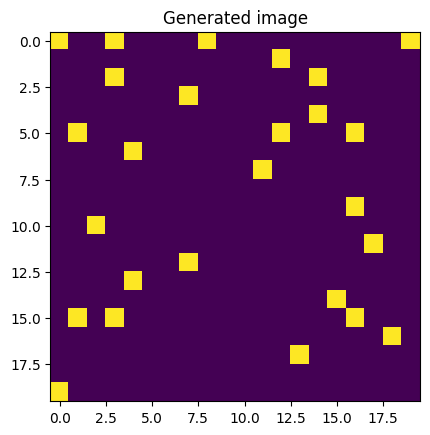

Epoch 9/20: 100%|██████████| 256/256 [01:19<00:00,  3.24it/s, train loss: 0.3880]


Validation Loss: 0.3857


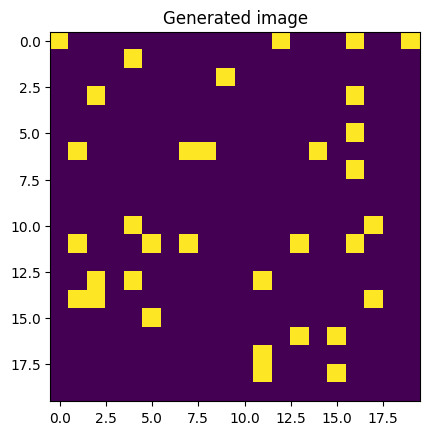

Epoch 10/20: 100%|██████████| 256/256 [01:18<00:00,  3.27it/s, train loss: 0.3880]


Validation Loss: 0.3857


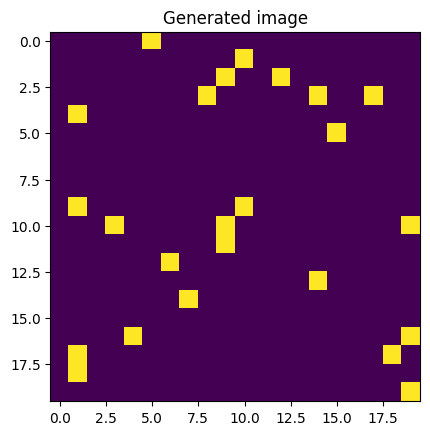

Epoch 11/20: 100%|██████████| 256/256 [01:17<00:00,  3.30it/s, train loss: 0.3880]


Validation Loss: 0.3857


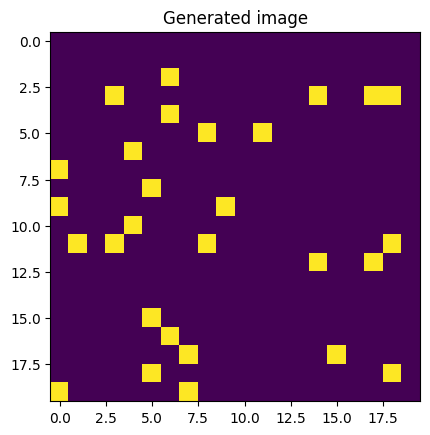

Epoch 12/20: 100%|██████████| 256/256 [01:18<00:00,  3.28it/s, train loss: 0.3880]


Validation Loss: 0.3857


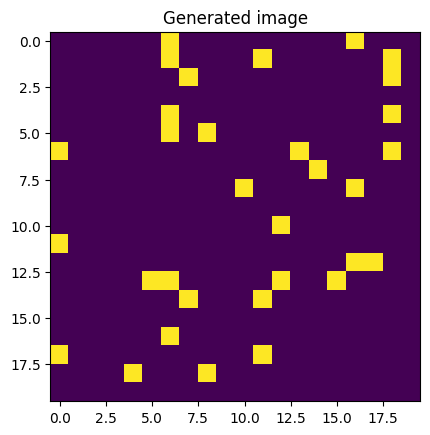

Epoch 13/20: 100%|██████████| 256/256 [01:19<00:00,  3.23it/s, train loss: 0.3880]


Validation Loss: 0.3857


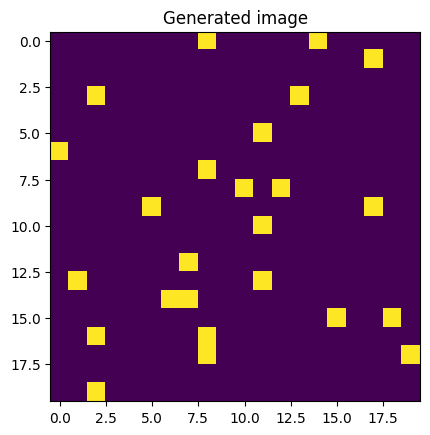

Epoch 14/20: 100%|██████████| 256/256 [01:20<00:00,  3.20it/s, train loss: 0.3880]


Validation Loss: 0.3857


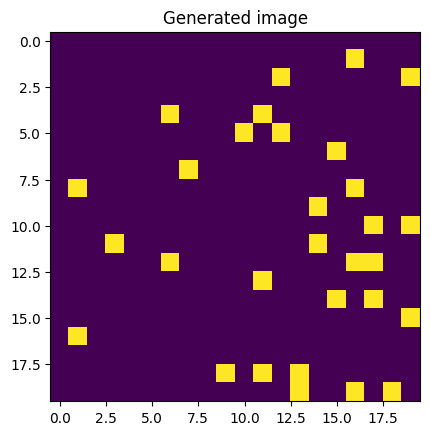

Epoch 15/20: 100%|██████████| 256/256 [01:20<00:00,  3.20it/s, train loss: 0.3880]


Validation Loss: 0.3857


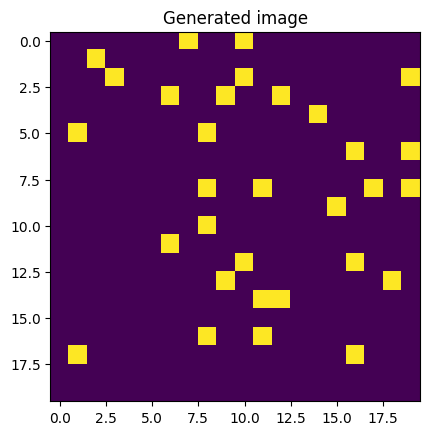

Epoch 16/20: 100%|██████████| 256/256 [01:18<00:00,  3.26it/s, train loss: 0.3880]


Validation Loss: 0.3857


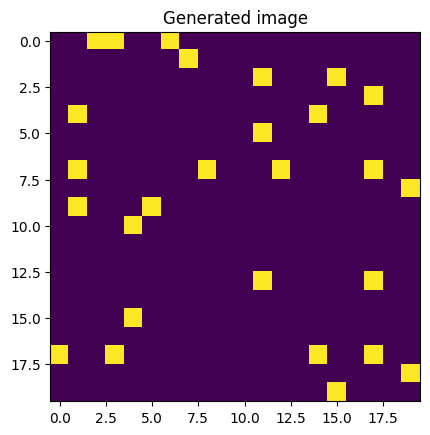

Epoch 17/20: 100%|██████████| 256/256 [01:17<00:00,  3.29it/s, train loss: 0.3880]


Validation Loss: 0.3857


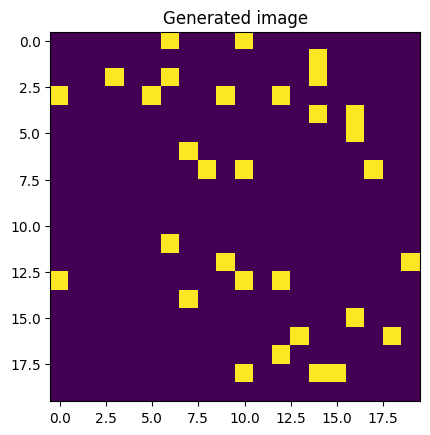

Epoch 18/20: 100%|██████████| 256/256 [01:18<00:00,  3.27it/s, train loss: 0.3880]


Validation Loss: 0.3857


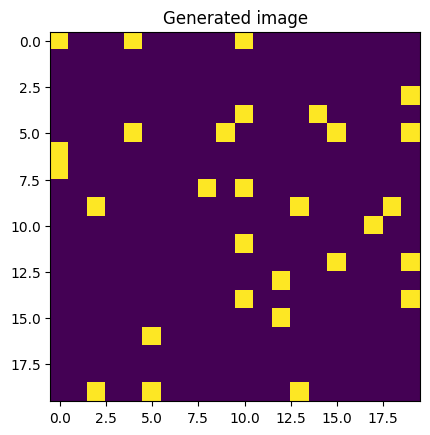

Epoch 19/20: 100%|██████████| 256/256 [01:18<00:00,  3.26it/s, train loss: 0.3880]


Validation Loss: 0.3857


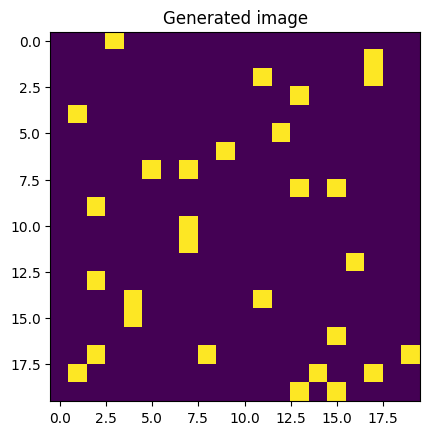

Epoch 20/20: 100%|██████████| 256/256 [01:27<00:00,  2.92it/s, train loss: 0.3880]


Validation Loss: 0.3857


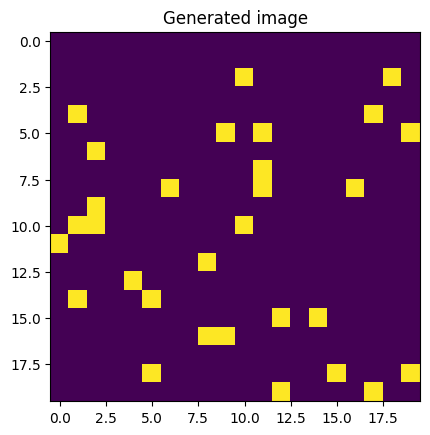




******* Train double layer model with silu *******


In [18]:
print('******* Train single layer model *******')
# signle_history = train_model(single_layer_model, train_loader, val_loader, epochs=20)
print('\n\n')
print('******* Train double layer model with relu *******')
double_r_history = train_model(double_layer_model_r, train_loader, val_loader, epochs=20)
print('\n\n')
print('******* Train double layer model with silu *******')
# double_s_history = train_model(double_layer_model_s, train_loader, val_loader, epochs=20)


In [19]:
# Save model weights
# torch.save(single_layer_model.state_dict(), f'/content/drive/MyDrive/DGM/HW2/weights/ss_{MARGIN}_{POSITIONAL}.pth')
torch.save(double_layer_model_r.state_dict(), f'/content/drive/MyDrive/DGM/HW2/weights/dr_{MARGIN}_{POSITIONAL}.pth')
# torch.save(double_layer_model_s.state_dict(), f'/content/drive/MyDrive/DGM/HW2/weights/ds_{MARGIN}_{POSITIONAL}.pth')

Generate samples for persian digits

<ipython-input-8-58bb2c42bf67>:87: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  blank[i, j] = pixel_value.cpu().detach().numpy()


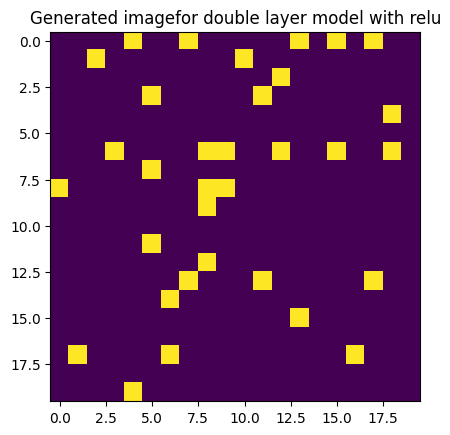

In [20]:
# Generate digit
# gen_im = single_layer_model.sample(np.zeros(shape=(20,20)))
# plt.figure()
# plt.imshow(gen_im)
# plt.title('Generated imagefor single layer model')
# plt.show()

gen_im = double_layer_model_r.sample(np.zeros(shape=(20,20)))
plt.figure()
plt.imshow(gen_im)
plt.title('Generated imagefor double layer model with relu')
plt.show()

# gen_im = double_layer_model_s.sample(np.zeros(shape=(20,20)))
# plt.figure()
# plt.imshow(gen_im)
# plt.title('Generated imagefor double layer model with silu')
# plt.show()

In [23]:
# save arrays of loss
folder_dir = '/content/drive/MyDrive/DGM/HW2/files'

# with open(os.path.join(folder_dir,f'ss_{MARGIN}_{POSITIONAL}.pkl' ), 'wb') as file:
#     pickle.dump(signle_history, file)
with open(os.path.join(folder_dir,f'dr_{MARGIN}_{POSITIONAL}.pkl' ), 'wb') as file:
    pickle.dump(double_r_history, file)
# with open(os.path.join(folder_dir,f'ds_{MARGIN}_{POSITIONAL}.pkl' ), 'wb') as file:
#     pickle.dump(signle_history, file)

# Margin size 2

## Positional = True

Read images to create trainnig data

In [31]:
MARGIN = 2
POSITIONAL = True

print('Create Train dataset')
X_train, y_train = create_dataset(f_train, l_train, MARGIN, POSITIONAL)
print('Create Validation dataset')
X_val, y_val = create_dataset(f_val, l_val, MARGIN, POSITIONAL)

Create Train dataset


100%|██████████| 10447/10447 [00:35<00:00, 294.55it/s]


Create Validation dataset


100%|██████████| 1305/1305 [00:03<00:00, 337.53it/s]


In [32]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

with open(f"scaler_{MARGIN}_{POSITIONAL}.pkl", "wb") as f:
    pickle.dump(scaler, f)

# with open("scaler.pkl", "rb") as f:
#     loaded_scaler = pickle.load(f)

In [33]:
X_val_tensor, y_val_tensor = model_input(X_val, y_val)
val_tensor = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_tensor, shuffle=False, batch_size=2**14)

X_train_tensor, y_train_tensor = model_input(X_train, y_train)
train_tensor = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_tensor, shuffle=False, batch_size=2**14)

In [34]:
X_train_tensor.shape

torch.Size([4178800, 10])

### Model

In [37]:
single_layer_model = BayesianNetwork(2, True, num_layer=1).to(device)
double_layer_model_r = BayesianNetwork(2, True, num_layer=2, activation='relu').to(device)
double_layer_model_s = BayesianNetwork(2, True, num_layer=2, activation='silu').to(device)

******* Train single layer model *******



******* Train double layer model with relu *******


<ipython-input-8-58bb2c42bf67>:87: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  blank[i, j] = pixel_value.cpu().detach().numpy()


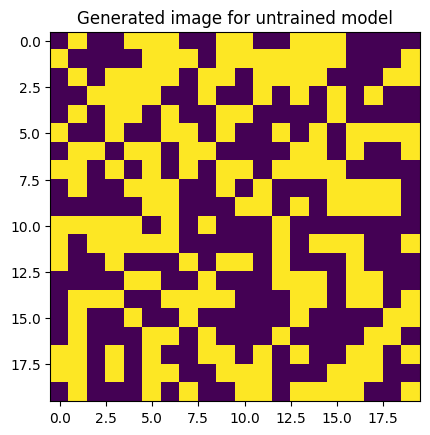

Epoch 1/10: 100%|██████████| 256/256 [01:21<00:00,  3.15it/s, train loss: 0.5800]


Validation Loss: 0.4650


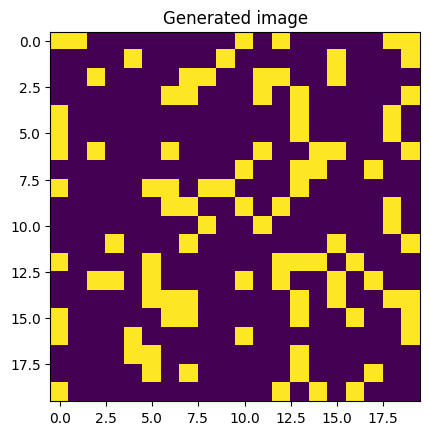

Epoch 2/10: 100%|██████████| 256/256 [01:20<00:00,  3.20it/s, train loss: 0.4327]


Validation Loss: 0.4111


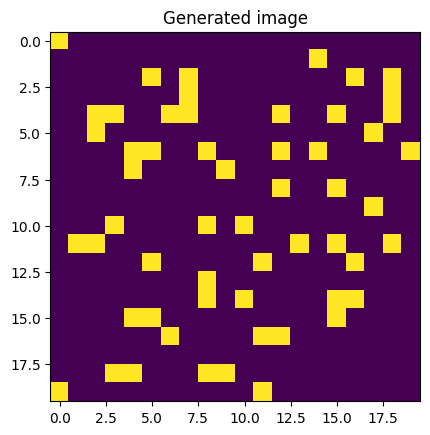

Epoch 3/10: 100%|██████████| 256/256 [01:19<00:00,  3.22it/s, train loss: 0.4053]


Validation Loss: 0.3997


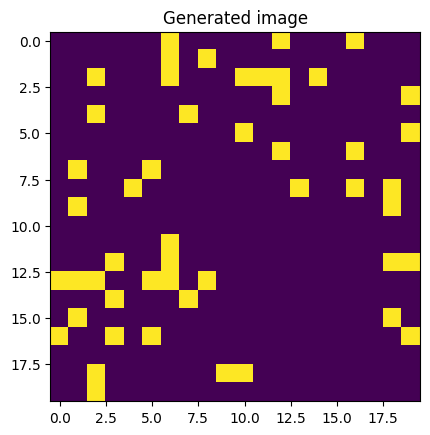

Epoch 4/10: 100%|██████████| 256/256 [01:19<00:00,  3.21it/s, train loss: 0.3993]


Validation Loss: 0.3970


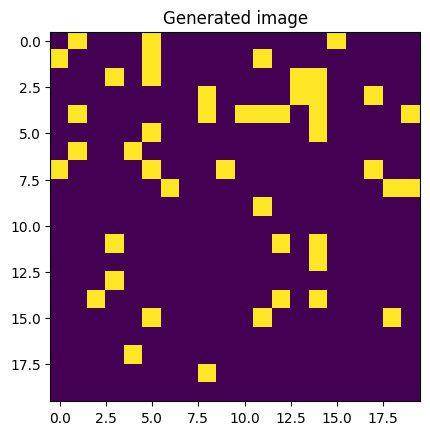

Epoch 5/10: 100%|██████████| 256/256 [01:19<00:00,  3.20it/s, train loss: 0.3978]


Validation Loss: 0.3963


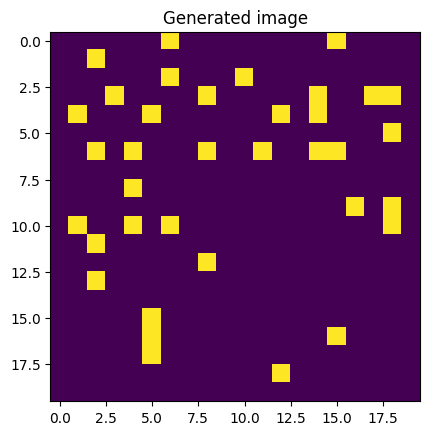

Epoch 6/10: 100%|██████████| 256/256 [01:20<00:00,  3.18it/s, train loss: 0.3973]


Validation Loss: 0.3960


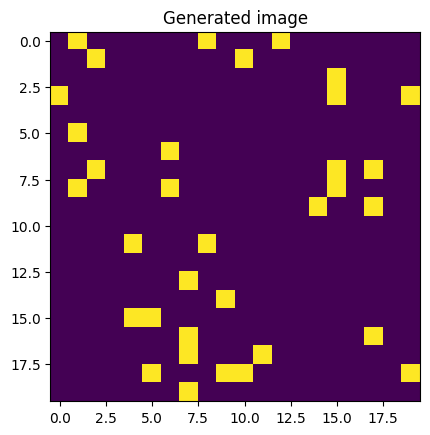

Epoch 7/10: 100%|██████████| 256/256 [01:19<00:00,  3.22it/s, train loss: 0.3972]


Validation Loss: 0.3959


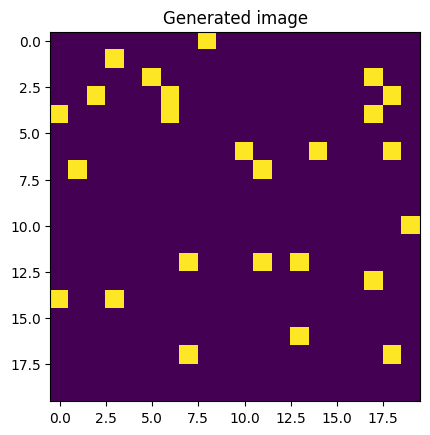

Epoch 8/10: 100%|██████████| 256/256 [01:20<00:00,  3.19it/s, train loss: 0.3971]


Validation Loss: 0.3958


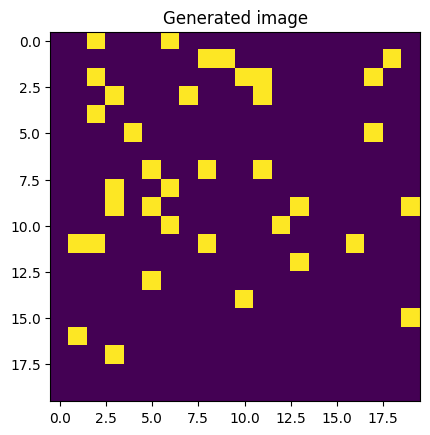

Epoch 9/10: 100%|██████████| 256/256 [01:20<00:00,  3.19it/s, train loss: 0.3970]


Validation Loss: 0.3958


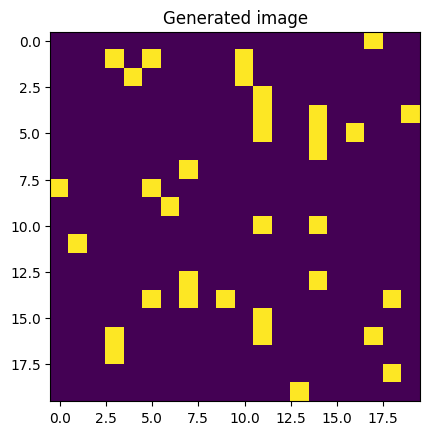

Epoch 10/10: 100%|██████████| 256/256 [01:20<00:00,  3.20it/s, train loss: 0.3970]


Validation Loss: 0.3957


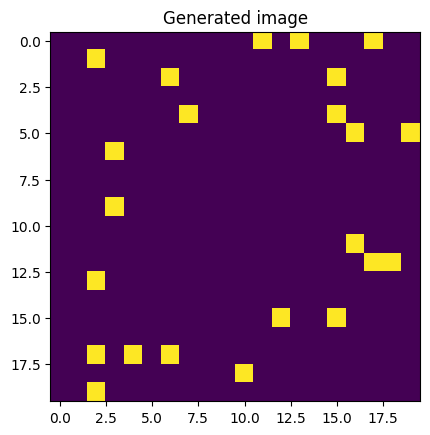




******* Train double layer model with silu *******


In [38]:
print('******* Train single layer model *******')
# signle_history = train_model(single_layer_model, train_loader, val_loader, epochs=20)
print('\n\n')
print('******* Train double layer model with relu *******')
double_r_history = train_model(double_layer_model_r, train_loader, val_loader, epochs=10)
print('\n\n')
print('******* Train double layer model with silu *******')
# double_s_history = train_model(double_layer_model_s, train_loader, val_loader, epochs=20)


In [39]:
# Save model weights
# torch.save(single_layer_model.state_dict(), f'/content/drive/MyDrive/DGM/HW2/weights/ss_{MARGIN}_{POSITIONAL}.pth')
torch.save(double_layer_model_r.state_dict(), f'/content/drive/MyDrive/DGM/HW2/weights/dr_{MARGIN}_{POSITIONAL}.pth')
# torch.save(double_layer_model_s.state_dict(), f'/content/drive/MyDrive/DGM/HW2/weights/ds_{MARGIN}_{POSITIONAL}.pth')

<ipython-input-8-58bb2c42bf67>:87: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  blank[i, j] = pixel_value.cpu().detach().numpy()


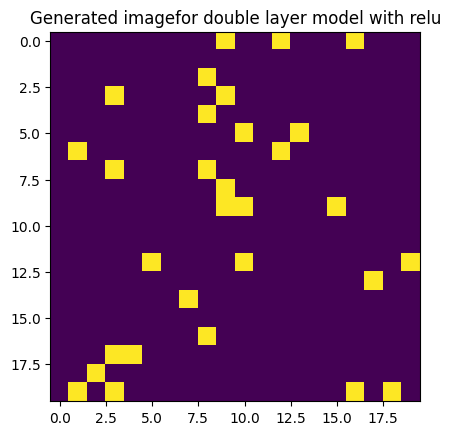

In [40]:
# Generate digit
# gen_im = single_layer_model.sample(np.zeros(shape=(20,20)))
# plt.figure()
# plt.imshow(gen_im)
# plt.title('Generated imagefor single layer model')
# plt.show()

gen_im = double_layer_model_r.sample(np.zeros(shape=(20,20)))
plt.figure()
plt.imshow(gen_im)
plt.title('Generated imagefor double layer model with relu')
plt.show()

# gen_im = double_layer_model_s.sample(np.zeros(shape=(20,20)))
# plt.figure()
# plt.imshow(gen_im)
# plt.title('Generated imagefor double layer model with silu')
# plt.show()

In [ ]:
# Plot loss history
plt.figure(figsize=(12,5))
# plt.plot(signle_history[0], 'g-', label='train loss (single model)')
# plt.plot(signle_history[1], 'g--', label='validation loss (single model)')
plt.plot(double_r_history[0], 'b-', label='train loss (double model with relu)')
plt.plot(double_r_history[1], 'b--', label='validation loss (double model with relu)')
# plt.plot(double_s_history[0], 'r-', label='train loss (double model with silu)')
# plt.plot(double_s_history[1], 'r--', label='validation loss (double model with silu)')

plt.title('Loss for different models')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

In [ ]:
# save arrays of loss
folder_dir = '/content/drive/MyDrive/DGM/HW2/files'

# with open(os.path.join(folder_dir,f'ss_{MARGIN}_{POSITIONAL}.pkl' ), 'wb') as file:
#     pickle.dump(signle_history, file)
with open(os.path.join(folder_dir,f'dr_{MARGIN}_{POSITIONAL}.pkl' ), 'wb') as file:
    pickle.dump(signle_history, file)
# with open(os.path.join(folder_dir,f'ds_{MARGIN}_{POSITIONAL}.pkl' ), 'wb') as file:
#     pickle.dump(signle_history, file)

## Positional = False

Read images to create trainnig data

In [ ]:
MARGIN = 2
POSITIONAL = False

print('Create Train dataset')
X_train, y_train = create_dataset(f_train, l_train, MARGIN, POSITIONAL)
print('Create Validation dataset')
X_val, y_val = create_dataset(f_val, l_val, MARGIN, POSITIONAL)

In [ ]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

with open(f"scaler_{MARGIN}_{POSITIONAL}.pkl", "wb") as f:
    pickle.dump(scaler, f)

# with open("scaler.pkl", "rb") as f:
#     loaded_scaler = pickle.load(f)

In [ ]:
X_val_tensor, y_val_tensor = model_input(X_val, y_val)
val_tensor = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_tensor, shuffle=False, batch_size=2**14)

X_train_tensor, y_train_tensor = model_input(X_train, y_train)
train_tensor = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_tensor, shuffle=False, batch_size=2**14)

### Model

In [ ]:
single_layer_model = BayesianNetwork(MARGIN, POSITIONAL, num_layer=1).to(device)
double_layer_model_r = BayesianNetwork(MARGIN, POSITIONAL, num_layer=2, activation='relu').to(device)
double_layer_model_s = BayesianNetwork(MARGIN, POSITIONAL, num_layer=2, activation='silu').to(device)

In [ ]:
print('******* Train single layer model *******')
signle_history = train_model(single_layer_model, train_loader, val_loader, epochs=20)
print('\n\n')
print('******* Train double layer model with relu *******')
double_r_history = train_model(double_layer_model_r, train_loader, val_loader, epochs=20)
print('\n\n')
print('******* Train double layer model with silu *******')
double_s_history = train_model(double_layer_model_s, train_loader, val_loader, epochs=20)


In [ ]:
# Save model weights
torch.save(single_layer_model.state_dict(), f'/content/drive/MyDrive/DGM/HW2/weights/ss_{MARGIN}_{POSITIONAL}.pth')
torch.save(double_layer_model_r.state_dict(), f'/content/drive/MyDrive/DGM/HW2/weights/dr_{MARGIN}_{POSITIONAL}.pth')
torch.save(double_layer_model_s.state_dict(), f'/content/drive/MyDrive/DGM/HW2/weights/ds_{MARGIN}_{POSITIONAL}.pth')

# Margin size 3

## Positional = True

Read images to create trainnig data

In [41]:
MARGIN = 3
POSITIONAL = True

print('Create Train dataset')
X_train, y_train = create_dataset(f_train, l_train, MARGIN, POSITIONAL)
print('Create Validation dataset')
X_val, y_val = create_dataset(f_val, l_val, MARGIN, POSITIONAL)

Create Train dataset


100%|██████████| 10447/10447 [00:35<00:00, 292.72it/s]


Create Validation dataset


100%|██████████| 1305/1305 [00:03<00:00, 337.46it/s]


In [42]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

with open(f"scaler_{MARGIN}_{POSITIONAL}.pkl", "wb") as f:
    pickle.dump(scaler, f)

# with open("scaler.pkl", "rb") as f:
#     loaded_scaler = pickle.load(f)

In [43]:
X_val_tensor, y_val_tensor = model_input(X_val, y_val)
val_tensor = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_tensor, shuffle=False, batch_size=2**14)

X_train_tensor, y_train_tensor = model_input(X_train, y_train)
train_tensor = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_tensor, shuffle=False, batch_size=2**14)

In [44]:
X_train_tensor.shape

torch.Size([4178800, 17])

### Model

In [45]:
single_layer_model = BayesianNetwork(3, True, num_layer=1).to(device)
double_layer_model_r = BayesianNetwork(3, True, num_layer=2, activation='relu').to(device)
double_layer_model_s = BayesianNetwork(3, True, num_layer=2, activation='silu').to(device)

******* Train single layer model *******



******* Train double layer model with relu *******


<ipython-input-8-58bb2c42bf67>:87: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  blank[i, j] = pixel_value.cpu().detach().numpy()


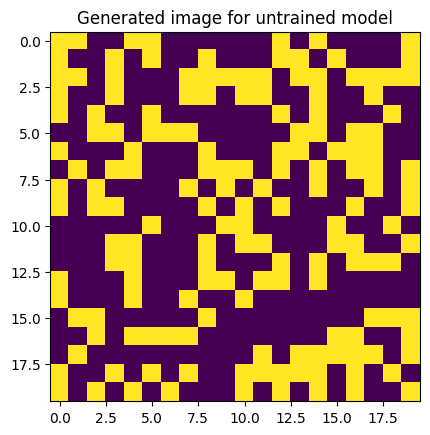

Epoch 1/10: 100%|██████████| 256/256 [01:19<00:00,  3.22it/s, train loss: 0.5876]


Validation Loss: 0.5027


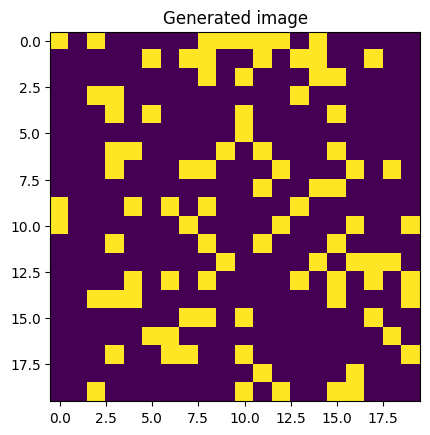

Epoch 2/10: 100%|██████████| 256/256 [01:19<00:00,  3.21it/s, train loss: 0.4693]


Validation Loss: 0.4474


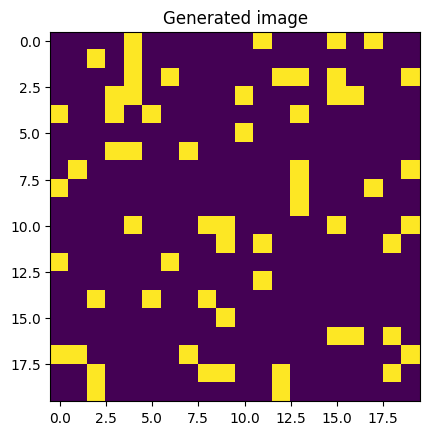

Epoch 3/10: 100%|██████████| 256/256 [01:19<00:00,  3.23it/s, train loss: 0.4311]


Validation Loss: 0.4206


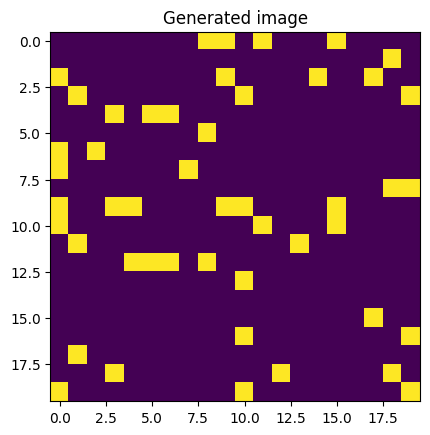

Epoch 4/10: 100%|██████████| 256/256 [01:19<00:00,  3.20it/s, train loss: 0.4191]


Validation Loss: 0.4105


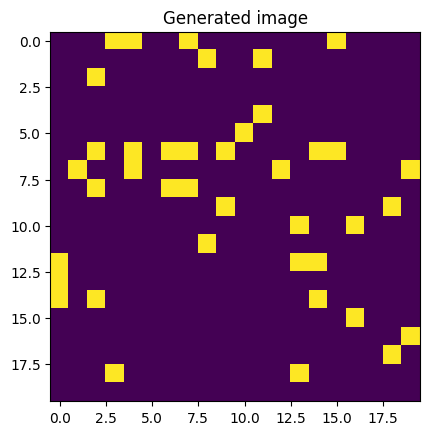

Epoch 5/10: 100%|██████████| 256/256 [01:19<00:00,  3.21it/s, train loss: 0.4141]


Validation Loss: 0.4091


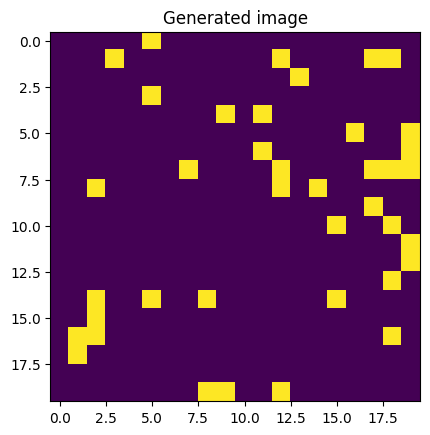

Epoch 6/10: 100%|██████████| 256/256 [01:20<00:00,  3.18it/s, train loss: 0.4115]


Validation Loss: 0.4082


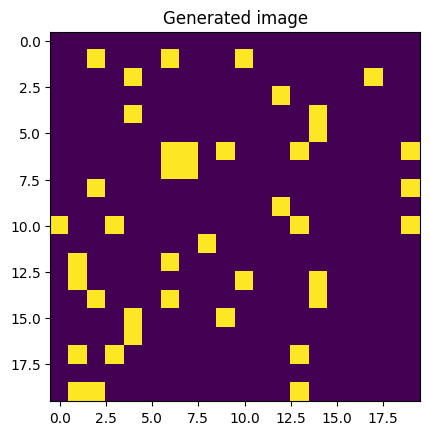

Epoch 7/10: 100%|██████████| 256/256 [01:19<00:00,  3.21it/s, train loss: 0.4102]


Validation Loss: 0.4056


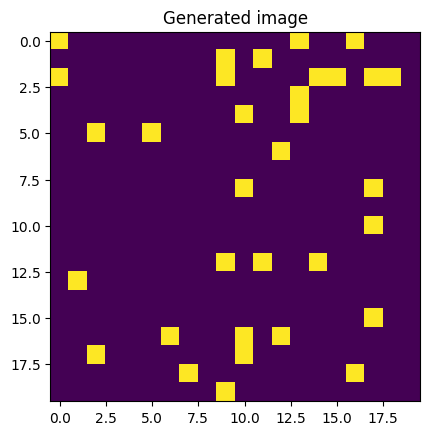

Epoch 8/10: 100%|██████████| 256/256 [01:20<00:00,  3.20it/s, train loss: 0.4098]


Validation Loss: 0.4082


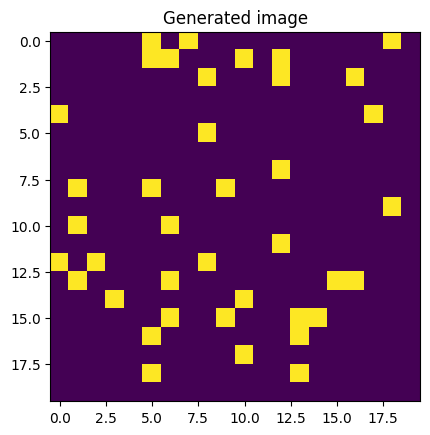

Epoch 9/10: 100%|██████████| 256/256 [01:19<00:00,  3.22it/s, train loss: 0.4090]


Validation Loss: 0.4038


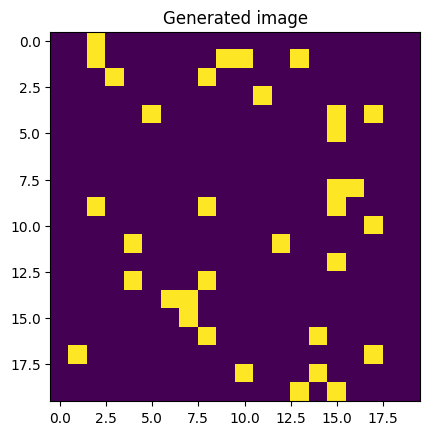

Epoch 10/10: 100%|██████████| 256/256 [01:20<00:00,  3.20it/s, train loss: 0.4089]


Validation Loss: 0.4034


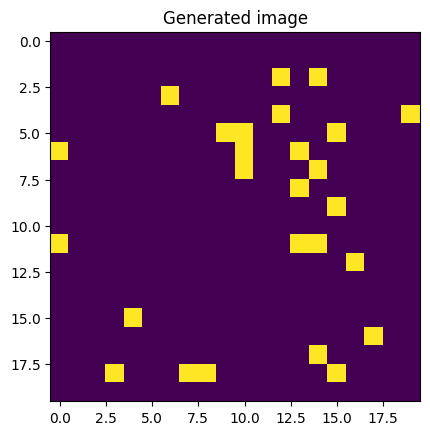




******* Train double layer model with silu *******


In [46]:
print('******* Train single layer model *******')
# signle_history = train_model(single_layer_model, train_loader, val_loader, epochs=20)
print('\n\n')
print('******* Train double layer model with relu *******')
double_r_history = train_model(double_layer_model_r, train_loader, val_loader, epochs=10)
print('\n\n')
print('******* Train double layer model with silu *******')
# double_s_history = train_model(double_layer_model_s, train_loader, val_loader, epochs=20)


In [47]:
# Save model weights
# torch.save(single_layer_model.state_dict(), f'/content/drive/MyDrive/DGM/HW2/weights/ss_{MARGIN}_{POSITIONAL}.pth')
torch.save(double_layer_model_r.state_dict(), f'/content/drive/MyDrive/DGM/HW2/weights/dr_{MARGIN}_{POSITIONAL}.pth')
# torch.save(double_layer_model_s.state_dict(), f'/content/drive/MyDrive/DGM/HW2/weights/ds_{MARGIN}_{POSITIONAL}.pth')

Generate samples of persian digits

<ipython-input-8-58bb2c42bf67>:87: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  blank[i, j] = pixel_value.cpu().detach().numpy()


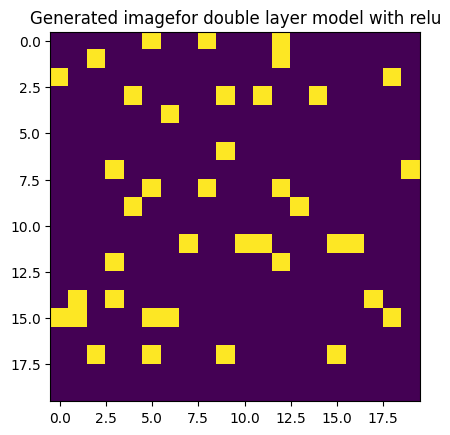

In [48]:
# Generate digit
# gen_im = single_layer_model.sample(np.zeros(shape=(20,20)))
# plt.figure()
# plt.imshow(gen_im)
# plt.title('Generated imagefor single layer model')
# plt.show()

gen_im = double_layer_model_r.sample(np.zeros(shape=(20,20)))
plt.figure()
plt.imshow(gen_im)
plt.title('Generated imagefor double layer model with relu')
plt.show()

# gen_im = double_layer_model_s.sample(np.zeros(shape=(20,20)))
# plt.figure()
# plt.imshow(gen_im)
# plt.title('Generated imagefor double layer model with silu')
# plt.show()

In [ ]:
# Plot loss history
plt.figure(figsize=(12,5))
# plt.plot(signle_history[0], 'g-', label='train loss (single model)')
# plt.plot(signle_history[1], 'g--', label='validation loss (single model)')
plt.plot(double_r_history[0], 'b-', label='train loss (double model with relu)')
plt.plot(double_r_history[1], 'b--', label='validation loss (double model with relu)')
# plt.plot(double_s_history[0], 'r-', label='train loss (double model with silu)')
# plt.plot(double_s_history[1], 'r--', label='validation loss (double model with silu)')

plt.title('Loss for different models')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

In [ ]:
# save arrays of loss
folder_dir = '/content/drive/MyDrive/DGM/HW2/files'

# with open(os.path.join(folder_dir,f'ss_{MARGIN}_{POSITIONAL}.pkl' ), 'wb') as file:
#     pickle.dump(signle_history, file)
with open(os.path.join(folder_dir,f'dr_{MARGIN}_{POSITIONAL}.pkl' ), 'wb') as file:
    pickle.dump(signle_history, file)
# with open(os.path.join(folder_dir,f'ds_{MARGIN}_{POSITIONAL}.pkl' ), 'wb') as file:
#     pickle.dump(signle_history, file)

## Positional = False

Read images to create trainnig data

In [ ]:
MARGIN = 3
POSITIONAL = False

print('Create Train dataset')
X_train, y_train = create_dataset(f_train, l_train, MARGIN, POSITIONAL)
print('Create Validation dataset')
X_val, y_val = create_dataset(f_val, l_val, MARGIN, POSITIONAL)

In [ ]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

with open(f"scaler_{MARGIN}_{POSITIONAL}.pkl", "wb") as f:
    pickle.dump(scaler, f)

# with open("scaler.pkl", "rb") as f:
#     loaded_scaler = pickle.load(f)

In [ ]:
X_val_tensor, y_val_tensor = model_input(X_val, y_val)
val_tensor = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_tensor, shuffle=False, batch_size=2**14)

X_train_tensor, y_train_tensor = model_input(X_train, y_train)
train_tensor = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_tensor, shuffle=False, batch_size=2**14)

### Model

In [ ]:
single_layer_model = BayesianNetwork(MARGIN, POSITIONAL, num_layer=1).to(device)
double_layer_model_r = BayesianNetwork(MARGIN, POSITIONAL, num_layer=2, activation='relu').to(device)
double_layer_model_s = BayesianNetwork(MARGIN, POSITIONAL, num_layer=2, activation='silu').to(device)

In [ ]:
print('******* Train single layer model *******')
signle_history = train_model(single_layer_model, train_loader, val_loader, epochs=20)
print('\n\n')
print('******* Train double layer model with relu *******')
double_r_history = train_model(double_layer_model_r, train_loader, val_loader, epochs=20)
print('\n\n')
print('******* Train double layer model with silu *******')
double_s_history = train_model(double_layer_model_s, train_loader, val_loader, epochs=20)


In [ ]:
# Save model weights
torch.save(single_layer_model.state_dict(), f'/content/drive/MyDrive/DGM/HW2/weights/ss_{MARGIN}_{POSITIONAL}.pth')
torch.save(double_layer_model_r.state_dict(), f'/content/drive/MyDrive/DGM/HW2/weights/dr_{MARGIN}_{POSITIONAL}.pth')
torch.save(double_layer_model_s.state_dict(), f'/content/drive/MyDrive/DGM/HW2/weights/ds_{MARGIN}_{POSITIONAL}.pth')

# Junk code

In [ ]:
im_size = 20
MARGIN = 1
single_layer_model.eval()

test_X, test_y, big_im = image2xy(test_im, MARGIN, POSITIONAL, True)
test_X_tensor = torch.tensor(test_X, dtype=torch.float32)

for i in range(test_X.shape[0]):
    test_X, test_y, big_im = image2xy(test_im, MARGIN, POSITIONAL, True)
    test_X_tensor = torch.tensor(test_X, dtype=torch.float32)
    test_x_tensor = test_X_tensor[i,:]
    with torch.no_grad():
        test_output = single_layer_model(test_x_tensor)


In [ ]:
out_im = test_output

tensor([[0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0

In [ ]:
import imageio

C:\Users\HAMI-PARS\AppData\Local\Temp\ipykernel_12632\4043898666.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  test_im = imageio.imread(test_dir)


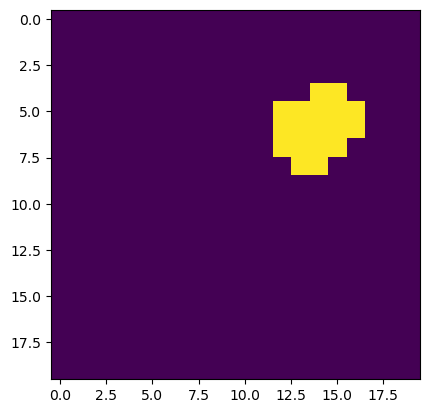

In [ ]:
test_dir = os.path.join(small_dir, l_train[50],f_train[50])
test_im = imageio.imread(test_dir)
plt.imshow(test_im)

the shape of the image is (20, 20)
the shape of the blank is (21, 21)


C:\Users\HAMI-PARS\AppData\Local\Temp\ipykernel_12632\3105447353.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  blank[i, j] = y_hat.cpu().detach().numpy()


Text(0.5, 1.0, 'Sample')

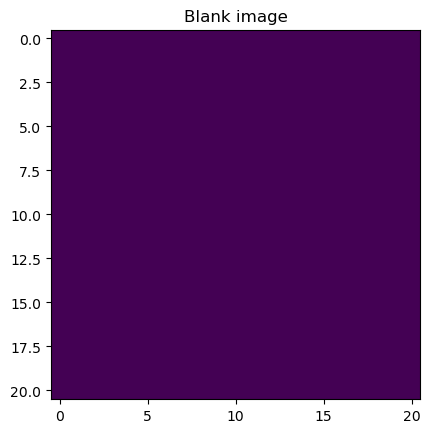

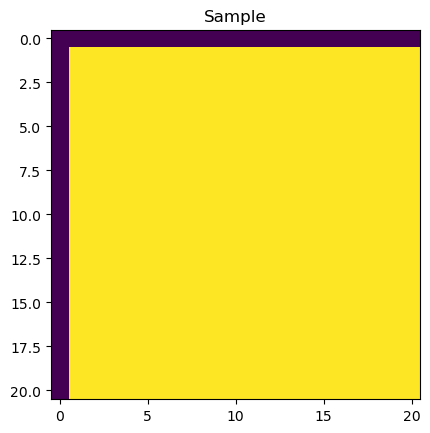

In [ ]:
np.max(blank)

0.5

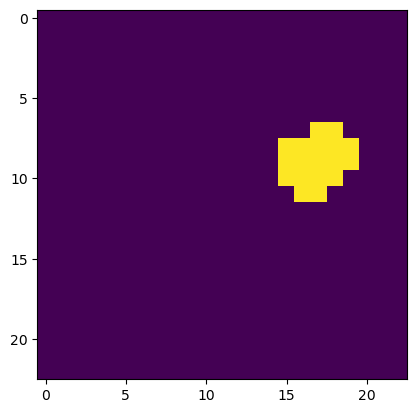

In [ ]:
margin = 3
shape_im = test_im.shape
new_im = np.zeros(shape=(shape_im[0]+margin, shape_im[1]+margin))
new_im[margin:, margin:] = test_im
plt.imshow(new_im)

In [ ]:
idx = np.arange(margin,new_im.shape[0])
positional = True

X_list = []
y_list = []

for i in idx:
    for j in idx:

        x = new_im[i-margin:i+1, j-margin:j+1].flatten()
        y = x[-1]
        x = x[:-1]
        if positional:
            ax_y = (i-margin)/idx.shape[0]
            ax_x = (j-margin)/idx.shape[0]
            x = np.append(x, [ax_x, ax_y])

        X_list.append(x)
        y_list.append(y)

X_list = np.array(X_list)
y_list = np.array(y_list)

print(X_list.shape)
print(y_list.shape)

(400, 17)
(400,)


In [ ]:
a,b = image_to_xy(test_dir, 2)
a.shape

C:\Users\HAMI-PARS\AppData\Local\Temp\ipykernel_1964\2171434557.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(path)


(400, 10)

In [ ]:
def train_model(model, train_loader, val_loader=None, n_jobs=None, epochs=5):
    EPOCHS = epochs
    if n_jobs:
        torch.set_num_threads(n_jobs) # Set number of core to be engaged

    # criterion = nn.NLLLoss()
    criterion = SingleNLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    train_loss_list = []
    train_iteration_loss_list = []
    val_loss_list = []

    try:
        for epoch in range(EPOCHS):
            model.train()

            t_loss = 0
            # Train loop
            train_iter = iter(train_loader)
            pbar = trange(len(train_iter),desc=f'Epoch {epoch+1}/{EPOCHS}')
            for i in pbar:
                X_batch, y_batch = next(train_iter)
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                y_batch_hat = model(X_batch)
                loss = criterion(y_batch_hat, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                t_loss += loss.item()
                train_iteration_loss_list.append(t_loss)
                pbar.set_postfix_str(f'train loss:{t_loss/(i+1):.4f}')

            t_loss *= 1/len(train_loader)
            train_loss_list.append(t_loss)

            if val_loader:
                # Validation
                model.eval()

                with torch.no_grad():
                    v_loss = 0
                    for batch in val_loader:
                        X_val, y_val = batch
                        X_val = X_val.to(device)
                        y_val = y_val.to(device)

                        y_val_hat = model(X_val)
                        loss = criterion(y_val_hat, y_val)
                        v_loss += loss.item()
                    val_loss_list.append(v_loss/len(val_loader))
                print(f'validation loss:{val_loss_list[-1]:.4f}')

        return train_loss_list, val_loss_list, train_iteration_loss_list
    except KeyboardInterrupt:
        print('\n\n!!!!!!!! Training has been stopped !!!!!!!!')
        return train_loss_list, val_loss_list, train_iteration_loss_list



history = train_model(single_layer_model, train_loader, val_loader, epochs=4)



Epoch 1/4:  39%|███▉      | 99/255 [00:05<00:08, 18.93it/s, train loss:1.0476]




!!!!!!!! Training has been stopped !!!!!!!!
